In [1]:
%load_ext autoreload
%autoreload 2

from utils.prediction_models import *

In [2]:
DIR_SI_figure_data="/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/"
DIR_data="/home/zeqianli/project/zeqian/Carbon/data"
zeqian=pd.read_pickle(f"{DIR_data}/zeqian/zeqian.pk")
matti=pd.read_pickle(f"{DIR_data}/matti/matti.pk")
bacdive=pd.read_pickle(f"{DIR_data}/bacdive/bacdive.pk")
datasets={"zeqian":zeqian,"matti":matti,"bacdive":bacdive,}

# bacdive_sim=pd.read_pickle("/home/zeqianli/project/zeqianli/Kuehn/Carbon/data/20221031_bacdive_simulated_data.pk")

# Figure 1 

# Figure 2

## FBA gapfilling


TODO: growth threshold

### 1. Gapfilled / non-gapfilled FBA vs null

In [16]:
DIR_figure="/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/fba_gapfilling/panel_1"


threads=1
models={'fba':[FBAClassifier,
                {'model_params':{c: {'c':c,
                                'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba.csv",
                                'growth_threshold':0.05} for c in CARBONS},
                'split_method':{c:[zeqian['growth_data'].index.values] for c in CARBONS},
                'threads':1,
                'allow_empty_set':True,
                'save_models':False
                }
                ],
        'fba_gapfill':[FBAClassifier,
                {'model_params':{c: {'c':c,
                                'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba_gapfill.csv",
                                'growth_threshold':0.05} for c in CARBONS},
                'split_method':{c:[zeqian['growth_data'].index.values] for c in CARBONS},
                'threads':1,
                'allow_empty_set':True,
                'save_models':False
                }
                ],
        'fba_force_uptake':[FBAClassifier,
                {'model_params':{c: {'c':c,
                                'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba_force_uptake.csv",
                                'growth_threshold':0.05} for c in CARBONS},
                'split_method':{c:[zeqian['growth_data'].index.values] for c in CARBONS},
                'threads':1,
                'allow_empty_set':True,
                'save_models':False
                }
                ],
        'fba_force_uptake_gapfill':[FBAClassifier,
                {'model_params':{c: {'c':c,
                                'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba_gapfill_force_uptake.csv",
                                'growth_threshold':0.05} for c in CARBONS},
                'split_method':{c:[zeqian['growth_data'].index.values] for c in CARBONS},
                'threads':1,
                'allow_empty_set':True,
                'save_models':False
                }
                ],
        'null': [BernoulliNull,
                {'model_params':{},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':10000,
                 'threads': threads,
                 'save_models':False
                 }],
        
        
}

matrices={'zeqian': zeqian}

In [17]:
results_all=run_multiple_models(models, matrices, DIR_figure, 
                    p=None)

Running models...
Running zeqian fba


Training models...: 100%|██████████| 10/10 [00:00<00:00, 41.78it/s]


Finished zeqian fba 
Running zeqian fba_gapfill


Training models...: 100%|██████████| 10/10 [00:00<00:00, 29.20it/s]


Finished zeqian fba_gapfill 
Running zeqian fba_force_uptake


Training models...: 100%|██████████| 10/10 [00:00<00:00, 46.34it/s]


Finished zeqian fba_force_uptake 
Running zeqian fba_force_uptake_gapfill


Training models...: 100%|██████████| 10/10 [00:00<00:00, 36.76it/s]


Finished zeqian fba_force_uptake_gapfill 
Running zeqian null


Training models...: 100%|██████████| 100000/100000 [03:56<00:00, 422.90it/s]


Finished zeqian null 
Running models done.
Concatenating data...
Concatenating data done.


In [18]:
results_all=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/fba_gapfilling/panel_1/results_all.pk")

model_pairs=[(m, 'null') for m in ['fba','fba_gapfill','fba_force_uptake','fba_force_uptake_gapfill']]
hue_order=['null', 'fba', 'fba_gapfill', 'fba_force_uptake', 'fba_force_uptake_gapfill']
stats=compare_models(results_all, 
                    model_pairs=[
                        (*model_pair, one_sample_test) for model_pair in model_pairs
                    ],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy',
                    p_threshold=0.05,
                    multi_testing_correction=False).set_index('carbon_name')

100%|██████████| 10/10 [00:00<00:00, 126.33it/s]


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glucuronic acid_null vs. Glucuronic acid_fba: Custom statistical test with Bonferroni correction, P_val:1.000e+00
Glycerol_null vs. Glycerol_fba: Custom statistical test with Bonferroni correction, P_val:1.000e+00
Arabinose_null vs. Arabinose_fba: Custom statistical test with Bonferroni correction, P_val:1.000e+00
Butyrate_null vs. Butyrate_fba: Custom statistical test with Bonferroni correction, P_val:1.000e+00
Deoxyribose_null vs. Deoxyribose_fba: Custom statistical test with Bonferroni correction, P_val:1.000e+00
Mannitol_null vs. Mannitol_fba: Custom statistical test with Bonferroni correction, P_val:1.000e+00
Mannose_null vs. Mannose_fba: Custom statistical test with Bonferroni correction, P_val:1.000e+00
Melibiose_null vs. Melibiose_fba: Custom statistical test with Bonferroni correction, P_val:1.000e+

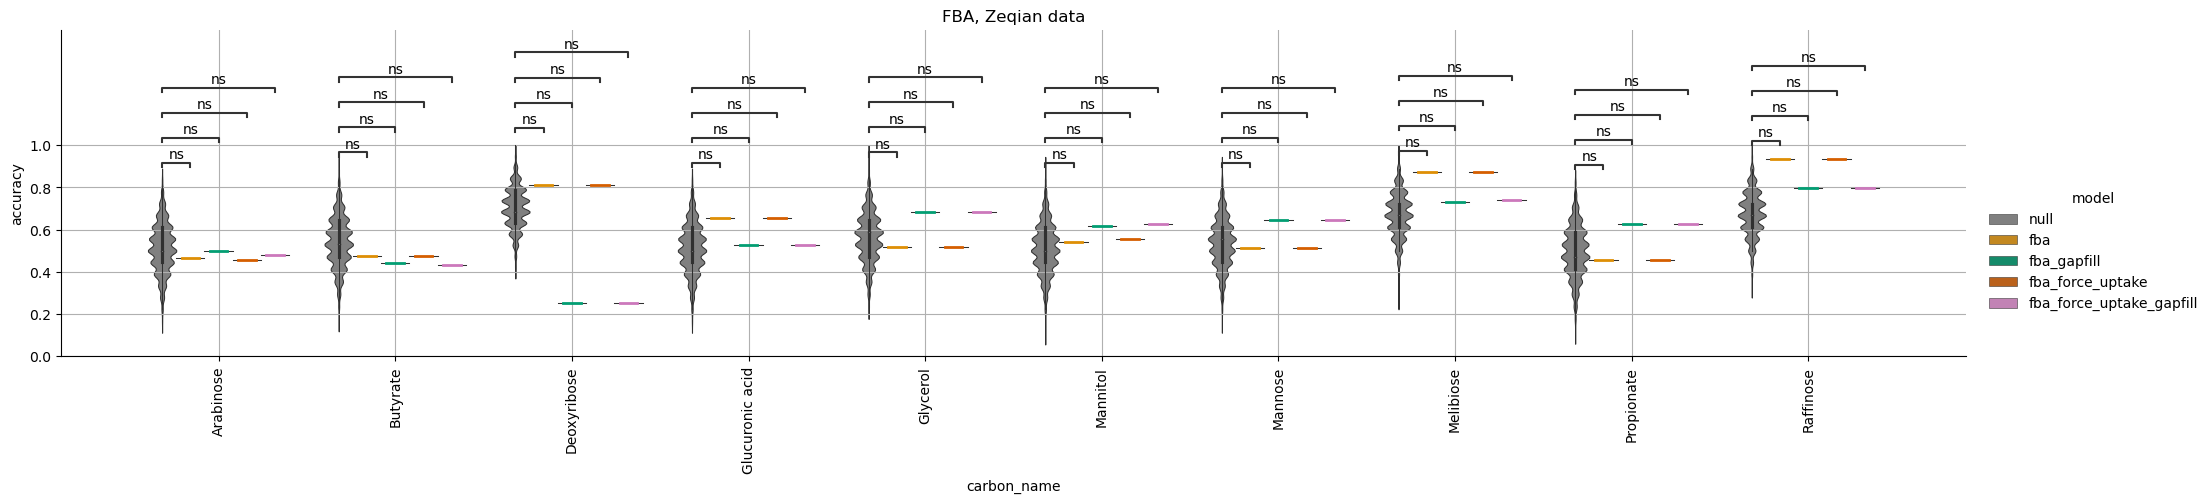

In [20]:
fig, stats=plot_fancy_model_comparison(results_all, hue_order=hue_order,stats=stats, model_pairs=model_pairs, multi_testing_correction=True, height=4, aspect=5)
fig.gca().set_title(f"FBA, Zeqian data")
fig

### 2. Gapfilled carbon prediction accuracy

In [64]:
DIR_multiple_gapfilling="/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/fba_gapfilling/fba_multiple_gapfills_olddata"

samples=np.unique([ff.split('-')[0] for ff in os.listdir(f"{DIR_multiple_gapfilling}/predictions")])
gf_carbons=['glc__D','succ','arab__L','but','drib','glcur','glyc','mnl','man','melib','ppa','raffin']
gf_carbons_name=['Glucose','Succinate','Arabinose','Butyrate','Deoxyribose','Glucuronic acid','Glycerol','Mannitol','Mannose','Melibiose','Propionate','Raffinose']
growth_threshold=0.05
bigg_id_map=pd.DataFrame([
        ['Arabinose', 'EX_arab__L_e'],
        ['Butyrate', 'EX_but_e'], # 'Butyrate'
        ['Deoxyribose', 'EX_drib_e'], 
        ['Glucuronic acid', 'EX_glcur_e'],
        ['Glycerol', 'EX_glyc_e'],
        ['Mannitol', 'EX_mnl_e'],
        ['Mannose', 'EX_man_e'],
        ['Melibiose', 'EX_melib_e'],
        ['Propionate', 'EX_ppa_e'], # 'Propionate'
        ['Raffinose', 'EX_raffin_e'],
    ],
    columns=['carbon_name','bigg_id']
)

for gf_c in tqdm(gf_carbons):
    growth_matrix={}
    growth_fu_matrix={}
    for sample in samples:
        growths=pd.read_csv(os.path.join(f"{DIR_multiple_gapfilling}/predictions",f"{sample}-{gf_c}.csv"),index_col=0,header=None).iloc[:,0]
        growth_matrix[sample]=growths
        growths=pd.read_csv(os.path.join(f"{DIR_multiple_gapfilling}/predictions",f"{sample}-{gf_c}_force_uptake.csv"),index_col=0,header=None).iloc[:,0]
        growth_fu_matrix[sample]=growths
    
    growth_matrix=pd.DataFrame(growth_matrix)
    growth_matrix.to_csv(f'{DIR_multiple_gapfilling}/prediction_matrices/{gf_c}.csv')

    growth_fu_matrix=pd.DataFrame(growth_fu_matrix)
    growth_fu_matrix.to_csv(f'{DIR_multiple_gapfilling}/prediction_matrices/{gf_c}_force_uptake.csv')

100%|██████████| 12/12 [00:08<00:00,  1.37it/s]


In [65]:
DIR_figure="/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/fba_gapfilling/panel_2"

threads=1
models={ # 'null': [BernoulliNull,
#                 {'model_params':{},
#                  'split_method':'random',
#                  'splitter_params': {'test_set_ratio':0.2}, 
#                  'n_splits':10000,
#                  'threads': threads,
#                  'save_models':False
#                  }],
    
}

shared_samples=np.intersect1d(zeqian['growth_data'].index.values, samples)

for gf_c,gf_c_name in tqdm(list(zip(gf_carbons,gf_carbons_name))):
    models.update({
        f'fba_gf_{gf_c_name}':[FBAClassifier,
                {'model_params':{c: {'c':c,
                                'growth':f"{DIR_multiple_gapfilling}/prediction_matrices/{gf_c}.csv",
                                'growth_threshold':0.05} for c in CARBONS},
                'split_method':{c:[shared_samples] for c in CARBONS},
                'threads':1,
                'allow_empty_set':True,
                'save_models':False
                }
                ],

        f'fba_fu_gf_{gf_c_name}':[FBAClassifier,
                {'model_params':{c: {'c':c,
                                'growth':f"{DIR_multiple_gapfilling}/prediction_matrices/{gf_c}_force_uptake.csv",
                                'growth_threshold':0.05} for c in CARBONS},
                'split_method':{c:[shared_samples] for c in CARBONS},
                'threads':1,
                'allow_empty_set':True,
                'save_models':False
                }
                ]
    })

matrices={'zeqian': {'growth_data':zeqian['growth_data'].loc[shared_samples,:],'ko_data':zeqian['ko_data'].loc[shared_samples,:],'tree':zeqian['tree'],'carbons':CARBONS}}

100%|██████████| 12/12 [00:00<00:00, 38836.15it/s]


In [66]:
results_all=run_multiple_models(models, matrices, DIR_figure, 
                    p=None)

Running models...
Running zeqian fba_gf_Glucose


Training models...: 100%|██████████| 10/10 [00:00<00:00, 57.50it/s]


Finished zeqian fba_gf_Glucose 
Running zeqian fba_fu_gf_Glucose


Training models...: 100%|██████████| 10/10 [00:00<00:00, 57.67it/s]


Finished zeqian fba_fu_gf_Glucose 
Running zeqian fba_gf_Succinate


Training models...: 100%|██████████| 10/10 [00:00<00:00, 61.29it/s]


Finished zeqian fba_gf_Succinate 
Running zeqian fba_fu_gf_Succinate


Training models...: 100%|██████████| 10/10 [00:00<00:00, 59.93it/s]


Finished zeqian fba_fu_gf_Succinate 
Running zeqian fba_gf_Arabinose


Training models...: 100%|██████████| 10/10 [00:00<00:00, 59.56it/s]


Finished zeqian fba_gf_Arabinose 
Running zeqian fba_fu_gf_Arabinose


Training models...: 100%|██████████| 10/10 [00:00<00:00, 59.54it/s]


Finished zeqian fba_fu_gf_Arabinose 
Running zeqian fba_gf_Butyrate


Training models...: 100%|██████████| 10/10 [00:00<00:00, 61.44it/s]


Finished zeqian fba_gf_Butyrate 
Running zeqian fba_fu_gf_Butyrate


Training models...: 100%|██████████| 10/10 [00:00<00:00, 58.78it/s]


Finished zeqian fba_fu_gf_Butyrate 
Running zeqian fba_gf_Deoxyribose


Training models...: 100%|██████████| 10/10 [00:00<00:00, 60.19it/s]


Finished zeqian fba_gf_Deoxyribose 
Running zeqian fba_fu_gf_Deoxyribose


Training models...: 100%|██████████| 10/10 [00:00<00:00, 58.03it/s]


Finished zeqian fba_fu_gf_Deoxyribose 
Running zeqian fba_gf_Glucuronic acid


Training models...: 100%|██████████| 10/10 [00:00<00:00, 61.00it/s]


Finished zeqian fba_gf_Glucuronic acid 
Running zeqian fba_fu_gf_Glucuronic acid


Training models...: 100%|██████████| 10/10 [00:00<00:00, 59.47it/s]


Finished zeqian fba_fu_gf_Glucuronic acid 
Running zeqian fba_gf_Glycerol


Training models...: 100%|██████████| 10/10 [00:00<00:00, 61.29it/s]


Finished zeqian fba_gf_Glycerol 
Running zeqian fba_fu_gf_Glycerol


Training models...: 100%|██████████| 10/10 [00:00<00:00, 58.48it/s]


Finished zeqian fba_fu_gf_Glycerol 
Running zeqian fba_gf_Mannitol


Training models...: 100%|██████████| 10/10 [00:00<00:00, 60.95it/s]


Finished zeqian fba_gf_Mannitol 
Running zeqian fba_fu_gf_Mannitol


Training models...: 100%|██████████| 10/10 [00:00<00:00, 57.39it/s]


Finished zeqian fba_fu_gf_Mannitol 
Running zeqian fba_gf_Mannose


Training models...: 100%|██████████| 10/10 [00:00<00:00, 60.08it/s]


Finished zeqian fba_gf_Mannose 
Running zeqian fba_fu_gf_Mannose


Training models...: 100%|██████████| 10/10 [00:00<00:00, 58.25it/s]


Finished zeqian fba_fu_gf_Mannose 
Running zeqian fba_gf_Melibiose


Training models...: 100%|██████████| 10/10 [00:00<00:00, 48.80it/s]


Finished zeqian fba_gf_Melibiose 
Running zeqian fba_fu_gf_Melibiose


Training models...: 100%|██████████| 10/10 [00:00<00:00, 57.92it/s]


Finished zeqian fba_fu_gf_Melibiose 
Running zeqian fba_gf_Propionate


Training models...: 100%|██████████| 10/10 [00:00<00:00, 60.23it/s]


Finished zeqian fba_gf_Propionate 
Running zeqian fba_fu_gf_Propionate


Training models...: 100%|██████████| 10/10 [00:00<00:00, 56.36it/s]


Finished zeqian fba_fu_gf_Propionate 
Running zeqian fba_gf_Raffinose


Training models...: 100%|██████████| 10/10 [00:00<00:00, 51.26it/s]


Finished zeqian fba_gf_Raffinose 
Running zeqian fba_fu_gf_Raffinose


Training models...: 100%|██████████| 10/10 [00:00<00:00, 57.12it/s]


Finished zeqian fba_fu_gf_Raffinose 
Running models done.
Concatenating data...
Concatenating data done.


In [81]:
results_all=pd.read_pickle(f"{DIR_figure}/results_all.pk")
df=results_all[results_all['model']!='null']
df['gf_c']=df['model'].str.replace('fba_gf_','').str.replace('fba_fu_gf_','')
df['force_uptake']=df['model'].str.contains('fba_fu_gf_')


df_fu=df[df['force_uptake']].pivot(index='carbon_name',columns='gf_c',values='accuracy')[['Glucose','Arabinose','Butyrate','Deoxyribose','Glucuronic acid','Glycerol','Mannitol','Mannose','Melibiose','Propionate','Raffinose']]
df=df[~df['force_uptake']].pivot(index='carbon_name',columns='gf_c',values='accuracy')[['Glucose','Arabinose','Butyrate','Deoxyribose','Glucuronic acid','Glycerol','Mannitol','Mannose','Melibiose','Propionate','Raffinose']]

for _ in [df,df_fu]:
    for c in _.index.values:
        _.at[c,c]=np.nan

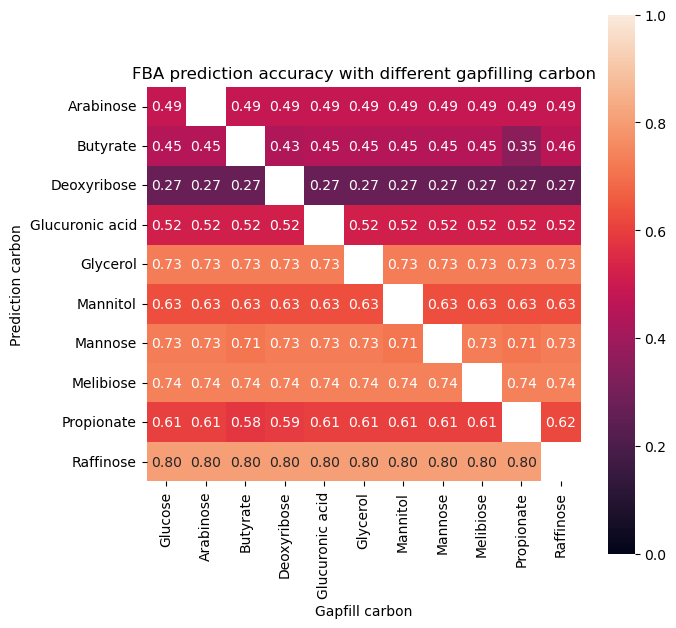

In [82]:
plt.figure(figsize=(7,7))
sns.heatmap(df,vmin=0,vmax=1,square=True,annot=True,fmt='.2f')
plt.xlabel("Gapfill carbon")
plt.ylabel('Prediction carbon')
plt.title("FBA prediction accuracy with different gapfilling carbon")
plt.gcf()

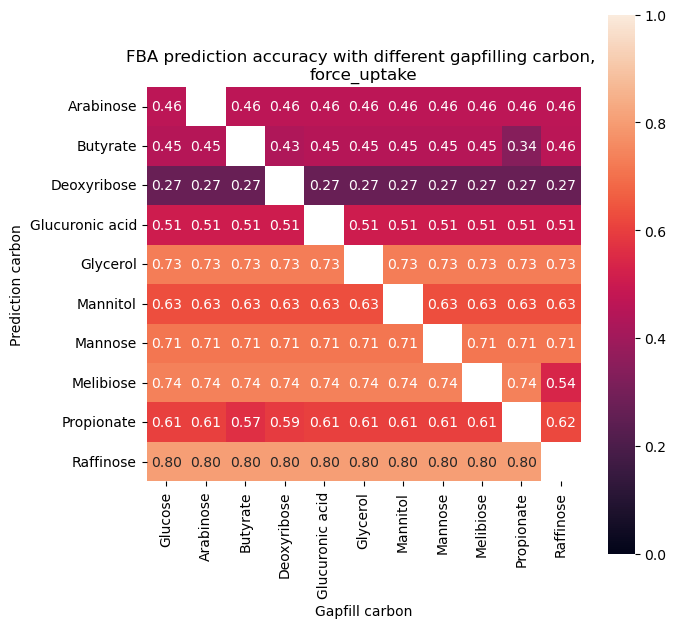

In [83]:
plt.figure(figsize=(7,7))
sns.heatmap(df_fu,vmin=0,vmax=1,square=True,annot=True,fmt='.2f')
plt.xlabel("Gapfill carbon")
plt.ylabel('Prediction carbon')
plt.title("FBA prediction accuracy with different gapfilling carbon, \nforce_uptake")
plt.gcf()

TODO: L1 distance of prediction vectors from different gapfilling carbons

## FBA sensitiviy vs precision

In [90]:
results_all=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/fba_gapfilling/panel_1/results_all.pk")
results_all=results_all[results_all['model']!='null']
results_all=results_all[~(results_all['model'].str.contains('force_uptake'))]

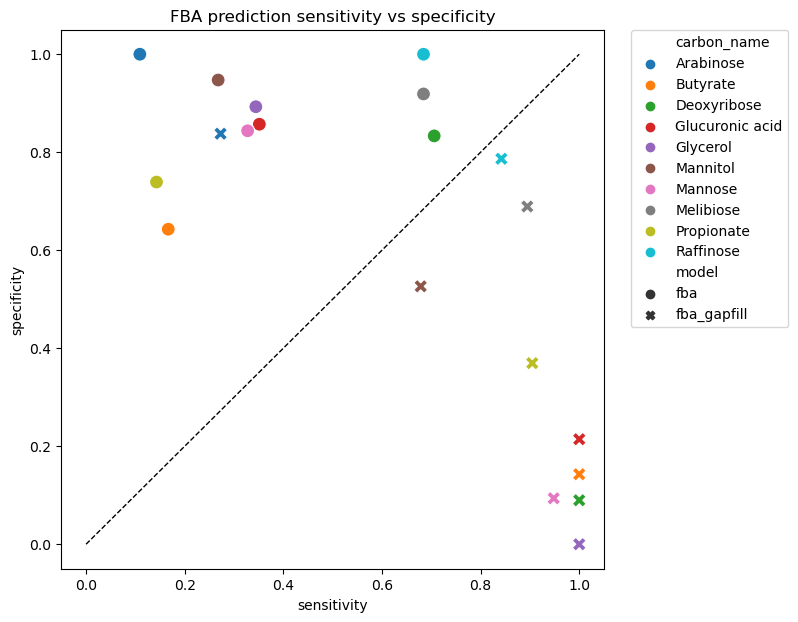

In [95]:
fig=plt.figure(figsize=(7,7))
sns.scatterplot(data=results_all,x='sensitivity',y='specificity',hue='carbon_name',style='model',s=100)
# legend out 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# line of y=x
plt.plot([0,1],[0,1],color='black',linestyle='--',linewidth=1)
plt.title("FBA prediction sensitivity vs specificity")
fig

## FBA growth threshold

In [11]:
growth = pd.read_csv("/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba.csv", index_col=0)
growth = growth.loc[FBAClassifier.bigg_id_map['bigg_id'].values, :]


Text(0.5, 0, 'Growth rate')

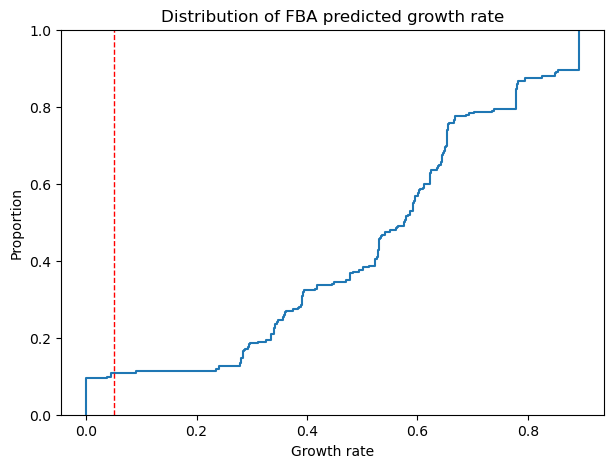

In [20]:
rates=growth.values.flatten()
sns.ecdfplot(rates[rates>0])
thresh=0.05
plt.plot([thresh,thresh],[0,1],color='red',linestyle='--',linewidth=1)
plt.title("Distribution of FBA predicted growth rate")
plt.xlabel("Growth rate")

In [10]:
growth

,HMWF001,HMWF003,HMWF004,HMWF005,HMWF006,HMWF007,HMWF008,HMWF009,HMWF010,HMWF011,HMWF013,HMWF014,HMWF015,HMWF016,HMWF017,HMWF018,HMWF019,HMWF021,HMWF022,HMWF023,HMWF025,HMWF026,HMWF028,HMWF029,HMWF030,HMWF031,HMWF032,HMWF034,HMWF035,HMWF036,OTU100,OTU2001,OTU2372,OTU2469,OTU3427,OTU364,OTU376,OTU3971,OTU4001,OTU4054,OTU4895,OTU4908,OTU5201,OTU530,OTU672,OTU695,OTU736,pd19367,sia0102,sia0103,sia0703,sia0901,sia0902,sia0905,sib0102,sib0112,sib0115,sib0205,sib0402,sib0404,sib0411,sib0509,sib0612,sic0102,sic0104,sic0105,sic0106,sic0204,sic0303,sic0402,sic0404,sic0604,sic0702,sic0904,sic1001,sic1004,sic1005,sic1102,sic1205,sic1506,sic1606,sid0102,sid0103,sid0104,sid0204,sid0205,sid0305,sid0306,sid0307,sid0404,sid0405,sid0406,sid0410,sid0505,sid0601,sid0605,sid0704,sid0705,sid0801,sid0802,sid0803,sid0901,sid0904,sid1001,sid1002,sid1005,sid1006,sie0102,sie1401,sie1413,sie1917,sie2115,sie2117,sif0513,sif0514,sif0532,sif0611,sif0612,sif0613,sif0617,sif0631,sif0632,sif0711,sif0715,sif0716,sif0732,sif1233,sif1632,sif1732,sif1734,sif1831,sif1833,sif2231,sif2232,sif2233,sif2331,sif2332,sif2416,sif2431,sif2433
EX_10fthf5glu_e,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
EX_10fthf6glu_e,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
EX_10fthf7glu_e,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
EX_10fthf_e,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.00

In [8]:
zl_fba_trait

,Unnamed: 0,HMWF001,HMWF003,HMWF004,HMWF005,HMWF006,HMWF007,HMWF008,HMWF009,HMWF010,HMWF011,HMWF013,HMWF014,HMWF015,HMWF016,HMWF017,HMWF018,HMWF019,HMWF021,HMWF022,HMWF023,HMWF025,HMWF026,HMWF028,HMWF029,HMWF030,HMWF031,HMWF032,HMWF034,HMWF035,HMWF036,OTU100,OTU2001,OTU2372,OTU2469,OTU3427,OTU364,OTU376,OTU3971,OTU4001,OTU4054,OTU4895,OTU4908,OTU5201,OTU530,OTU672,OTU695,OTU736,pd19367,sia0102,sia0103,sia0703,sia0901,sia0902,sia0905,sib0102,sib0112,sib0115,sib0205,sib0402,sib0404,sib0411,sib0509,sib0612,sic0102,sic0104,sic0105,sic0106,sic0204,sic0303,sic0402,sic0404,sic0604,sic0702,sic0904,sic1001,sic1004,sic1005,sic1102,sic1205,sic1506,sic1606,sid0102,sid0103,sid0104,sid0204,sid0205,sid0305,sid0306,sid0307,sid0404,sid0405,sid0406,sid0410,sid0505,sid0601,sid0605,sid0704,sid0705,sid0801,sid0802,sid0803,sid0901,sid0904,sid1001,sid1002,sid1005,sid1006,sie0102,sie1401,sie1413,sie1917,sie2115,sie2117,sif0513,sif0514,sif0532,sif0611,sif0612,sif0613,sif0617,sif0631,sif0632,sif0711,sif0715,sif0716,sif0732,sif1233,sif1632,sif1732,sif1734,sif1831,sif1833,sif2231,sif2232,sif2233,sif2331,sif2332,sif2416,sif2431,sif2433
0,EX_10fthf5glu_e,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
1,EX_10fthf6glu_e,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2,EX_10fthf7glu_e,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
3,EX_10fthf_e,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000

## Matti FBA

TODO: his media is completely differnt from mine. Need another base media recipe. 

In [22]:
import re

DIR_matti="/home/zeqianli/project/zeqian/Carbon/data/matti"

def find_sample_name(ff):
    return ff.replace('.csv','').replace('_gapfill','').replace('_force_uptake','').split('/')[-1]

def concatenate(ffs,output):
    growths=[pd.read_csv(ff,index_col=0,names=[find_sample_name(ff)]) for ff in ffs]
    growth_matrix=pd.concat(growths,axis=1)
    return growth_matrix

DIR_fba=f"{DIR_matti}/fba_prediction"
DIR_fba_concat=f"{DIR_matti}/fba_concatenated"
samples=np.unique([find_sample_name(ff) for ff in os.listdir(DIR_fba)])
thresh=0.05

for suffix in ['','_gapfill','_force_uptake','_gapfill_force_uptake']:
    ffs=[os.path.join(DIR_fba,samples+suffix+'.csv') for samples in samples]
    growth_matrix=concatenate(ffs,os.path.join(DIR_matti,'fba_prediction'+suffix+'.csv'))
    growth_matrix.to_csv(os.path.join(DIR_fba_concat,'matti_fba'+suffix+'.csv'))
    (growth_matrix>thresh).astype(int).to_csv(os.path.join(DIR_fba_concat,'matti_fba'+suffix+f'_binarized_{thresh}.csv'))


TODO: make bigg id map of matti's strains

## Taxonomy - trait

Mean trait/16S distances per same phylum/genus/species/etc. 

In [4]:
DIR_bacdive="/home/zeqianli/project/zeqian/Carbon/data/bacdive"

In [39]:
def get_utilization_data(record,keys=['Chebi-ID','metabolite','utilization activity','kind of utilization tested']):
    # TODO: specify if the data source is api-test or not
    bacdive_id=record['General']['BacDive-ID']
    outs=[]
    try:
        records=record['Physiology and metabolism']['metabolite utilization']
        if isinstance(records,dict):
            records=[records] # Use the first record for now. 
    except KeyError:
        return outs
    
    for r in records:
        out={'id':bacdive_id}
        for k in keys:
            try:
                out[k]=str(r[k])
            except KeyError:
                out[k]=None
        outs.append(out)
    return outs

raw=pd.read_pickle(f"{DIR_bacdive}/raw/raw.pk")
df_utilization=[]
for record in raw:
    df_utilization+=get_utilization_data(record)
df_utilization=pd.DataFrame(df_utilization,dtype=str)

In [6]:
df_utilization

,id,Chebi-ID,metabolite,utilization activity,kind of utilization tested
0,166226,17108,D-arabinose,+,builds acid from
1,166226,30849,L-arabinose,+,builds acid from
2,166226,16988,D-ribose,+,builds acid from
3,166226,65327,D-xylose,+,builds acid from
4,166226,65328,L-xylose,+,builds acid from
...,...,...,...,...,...
211297,66,16199,urea,+,hydrolysis
211298,66,29016,arginine,-,hydrolysis
211299,66,17634,D-glucose,-,fermentation
211300,66,27897,tryptophan,-,energy source


In [40]:
df_utilization=df_utilization[df_utilization['kind of utilization tested'].isin(['energy source','carbon source'])] # Filter out other kinds of utilization.
df_utilization=df_utilization[df_utilization['utilization activity'].isin(['+','-'])] # Remove uncertain records.
df_utilization['metabolite_short']=df_utilization['metabolite'].copy()
df_utilization['metabolite_short']=df_utilization['metabolite_short'].str.replace('D-','').str.replace('L-','') # Remove D- and L- prefix. # TODO: check if this is valid in the future. Any strains that grow on one but not the other?
df_utilization['metabolite_short']=df_utilization['metabolite_short'].str.replace('\w*sodium\ +','',regex=True).replace('\w*potassium\ +','',regex=True) 
df_utilization['metabolite_short']=df_utilization['metabolite_short'].str.replace(r'\(.*\)- *','',regex=True) # braket prefixes. # TODO: check if this is valid in the future.
df_utilization['metabolite_short']=df_utilization['metabolite_short'].str.replace(r'\d+ *%','',regex=True) # braket prefixes. # TODO: check if this is valid in the future.

In [31]:
df_utilization.shape, df_utilization[['id','metabolite_short']].nunique()

id                  5877
metabolite_short     421
dtype: int64

In [24]:
df_special_case=df_utilization.groupby(['id','metabolite_short']).filter(lambda x: (x['utilization activity'].nunique()>1) and (x['metabolite'].nunique()>1)).sort_values(['id','metabolite_short'])
df_special_case.shape,df_special_case[['id','metabolite_short']].nunique()

Out of 54076 records (5877 stains, 421 metabolites), only 296 conflicting records (94 strains, 17 shortened metabolite names) are created by the name shortening. Proceed with the shortened name and remove these records. 

# Figure 3

## RF hyperparameters

In [111]:
DIR_figure="/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/rf_hyperparameters"

In [5]:
# Run this cell after testing

threads=48
# p=Pool(threads)

models_params={'null': [BernoulliNull,None],
        'RF_None_sqrt':[RF,{'n_estimators':100,'max_depth':None, 'max_features': 'sqrt'}],
        'RF_5_sqrt':[RF,{'n_estimators':100,'max_depth':5, 'max_features': 'sqrt'}],
        'RF_1_sqrt':[RF,{'n_estimators':100,'max_depth':1, 'max_features': 'sqrt'}],
        'RF_None_None':[RF,{'n_estimators':100,'max_depth':None, 'max_features': None}],
        'RF_5_None':[RF,{'n_estimators':100,'max_depth':5, 'max_features': None}],
        'RF_1_None':[RF,{'n_estimators':100,'max_depth':1, 'max_features': None}],
        }
        # 'NN': [NearestNeighbor,None], "LogisticRegression":[LassoLogisticRegression,{'C':1.0, 'penalty':'l1','solver':'liblinear'}]}

split_params={'random': {
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 },
        'ooc': {
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }
        # 'loo':{
        #          'split_method':'leave_one_out',
        #          'splitter_params': {}, 
        #          'n_splits':None,
        #          'threads': threads,
        #          'save_models':False
        #          }
        }

models={}
for model_name, (Model, model_params) in models_params.items():
    for split_name, split_param in split_params.items():
        params=split_param.copy()
        params.update({'model_params': model_params})
        models[f"{model_name}_{split_name}"]=[Model, params]

datasets={'zeqian':zeqian}

In [ ]:
results_all=run_multiple_models(models, matrices, DIR_figure, 
                    p=None)

Running models...
Running zeqian fba


Training models...: 100%|██████████| 10/10 [00:00<00:00, 41.78it/s]


Finished zeqian fba 
Running zeqian fba_gapfill


Training models...: 100%|██████████| 10/10 [00:00<00:00, 29.20it/s]


Finished zeqian fba_gapfill 
Running zeqian fba_force_uptake


Training models...: 100%|██████████| 10/10 [00:00<00:00, 46.34it/s]


Finished zeqian fba_force_uptake 
Running zeqian fba_force_uptake_gapfill


Training models...: 100%|██████████| 10/10 [00:00<00:00, 36.76it/s]


Finished zeqian fba_force_uptake_gapfill 
Running zeqian null


Training models...: 100%|██████████| 100000/100000 [03:56<00:00, 422.90it/s]


Finished zeqian null 
Running models done.
Concatenating data...
Concatenating data done.


### Plot

In [115]:
results_all=pd.read_pickle(f"{DIR_figure}/zeqian_results_all.pk")

In [118]:
split='random'
df=results_all[results_all['split']==split]
model_pairs=[(m, 'null') for m in ['RF_None_sqrt', 'RF_5_sqrt', 'RF_1_sqrt', 'RF_None_None',
       'RF_5_None', 'RF_1_None']]
hue_order=['null','RF_None_sqrt', 'RF_5_sqrt', 'RF_1_sqrt', 'RF_None_None',
       'RF_5_None', 'RF_1_None'] # 'RF_1_ooc','RF_5_ooc'
stats=compare_models(results_all, 
                    model_pairs=[
                        (*model_pair, ttest_permutation) for model_pair in model_pairs
                    ],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy',
                    p_threshold=0.05,
                    multi_testing_correction=False).set_index('carbon_name')

100%|██████████| 10/10 [01:11<00:00,  7.16s/it]


In [126]:
fig, stats=plot_fancy_model_comparison(df, hue_order=hue_order,stats=stats, model_pairs=model_pairs, multi_testing_correction=True, height=4, aspect=6)
fig.gca().set_title(f"Random split")
plt.ylim(0,1)
fig

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mannitol_null vs. Mannitol_RF_None_sqrt: Custom statistical test with Bonferroni correction, P_val:6.000e-04
Mannose_null vs. Mannose_RF_None_sqrt: Custom statistical test with Bonferroni correction, P_val:6.000e-04
Melibiose_null vs. Melibiose_RF_None_sqrt: Custom statistical test with Bonferroni correction, P_val:6.000e-04
Propionate_null vs. Propionate_RF_None_sqrt: Custom statistical test with Bonferroni correction, P_val:6.000e-04
Butyrate_null vs. Butyrate_RF_None_sqrt: Custom statistical test with Bonferroni correction, P_val:6.000e-04
Arabinose_null vs. Arabinose_RF_None_sqrt: Custom statistical test with Bonferroni correction, P_val:6.000e-04
Deoxyribose_null vs. Deoxyribose_RF_None_sqrt: Custom statistical test with Bonferroni correction, P_val:6.000e-04
Glucuronic acid_null vs. Glucuronic acid_RF_

(0.0, 1.0)

In [124]:
split='ooc'
df=results_all[results_all['split']==split]
model_pairs=[(m, 'null') for m in ['RF_None_sqrt', 'RF_5_sqrt', 'RF_1_sqrt', 'RF_None_None',
       'RF_5_None', 'RF_1_None']]
hue_order=['null','RF_None_sqrt', 'RF_5_sqrt', 'RF_1_sqrt', 'RF_None_None',
       'RF_5_None', 'RF_1_None'] # 'RF_1_ooc','RF_5_ooc'
stats=compare_models(results_all, 
                    model_pairs=[
                        (*model_pair, ttest_permutation) for model_pair in model_pairs
                    ],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy',
                    p_threshold=0.05,
                    multi_testing_correction=False).set_index('carbon_name')

100%|██████████| 10/10 [01:09<00:00,  6.94s/it]


In [128]:
stats

stat,RF_1_None_null_p,RF_1_None_null_significant,RF_1_None_null_t,RF_1_sqrt_null_p,RF_1_sqrt_null_significant,RF_1_sqrt_null_t,RF_5_None_null_p,RF_5_None_null_significant,RF_5_None_null_t,RF_5_sqrt_null_p,RF_5_sqrt_null_significant,RF_5_sqrt_null_t,RF_None_None_null_p,RF_None_None_null_significant,RF_None_None_null_t,RF_None_sqrt_null_p,RF_None_sqrt_null_significant,RF_None_sqrt_null_t
carbon_name,,,,,,,,,,,,,,,,,,
Arabinose,0.00001,True,17.547942,0.00001,True,9.882192,0.00001,True,17.436507,0.00001,True,11.360114,0.00001,True,17.986412,0.00001,True,10.723475
Butyrate,0.00001,True,6.389489,0.00001,True,18.648437,0.00001,True,9.04501,0.00001,True,17.392415,0.00001,True,8.898589,0.00001,True,19.546215
Deoxyribose,0.00001,True,8.647761,0.00001,True,9.064828,0.00001,True,10.923984,0.00001,True,8.623184,0.00001,True,9.161575,0.00001,True,7.031706
Glucuronic acid,0.00001,True,7.195845,0.00001,True,9.996131,0.00001,True,12.91343,0.00001,True,12.509313,0.00001,True,9.210521,0.00001,True,13.796418
Glycerol,0.00001,True,14.015922,0.00001,True,14.234038,0.00001,True,15.180012,0.00001,True,10.525166,0.00001,True,13.115721,0.00001,True,9.724969
Mannitol,0.00001,True,13.19126,0.00001,True,5.313995,0.00001,True,10.988683,0.00001,True,8.233158,0.00001,True,11.542836,0.00001,True,7.996063
Mannose,0.00001,True,9.106648,0.00489,True,2.834479,0.00001,True,8.533425,0.00001,True,7.606591,0.00001,True,8.64256,0.00001,True,6.677337
Melibiose,0.00001,True,9.447376,0.00001,True,11.827761,0.00001,True,10.293321,0.00001,True,11.468181,0.00001,True,11.52848,0.00001,True,11.220202
Propionate,0.00001,True,16.99429,0.00001,True,13.184064,0.00001,True,17.053642,0.00001,True,17.975372,0.00001,True,17.413736,0.00001,True,18.505643


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mannitol_null vs. Mannitol_RF_None_sqrt: Custom statistical test with Bonferroni correction, P_val:6.000e-04
Mannose_null vs. Mannose_RF_None_sqrt: Custom statistical test with Bonferroni correction, P_val:6.000e-04
Melibiose_null vs. Melibiose_RF_None_sqrt: Custom statistical test with Bonferroni correction, P_val:6.000e-04
Propionate_null vs. Propionate_RF_None_sqrt: Custom statistical test with Bonferroni correction, P_val:6.000e-04
Butyrate_null vs. Butyrate_RF_None_sqrt: Custom statistical test with Bonferroni correction, P_val:6.000e-04
Arabinose_null vs. Arabinose_RF_None_sqrt: Custom statistical test with Bonferroni correction, P_val:6.000e-04
Deoxyribose_null vs. Deoxyribose_RF_None_sqrt: Custom statistical test with Bonferroni correction, P_val:6.000e-04
Glucuronic acid_null vs. Glucuronic acid_RF_

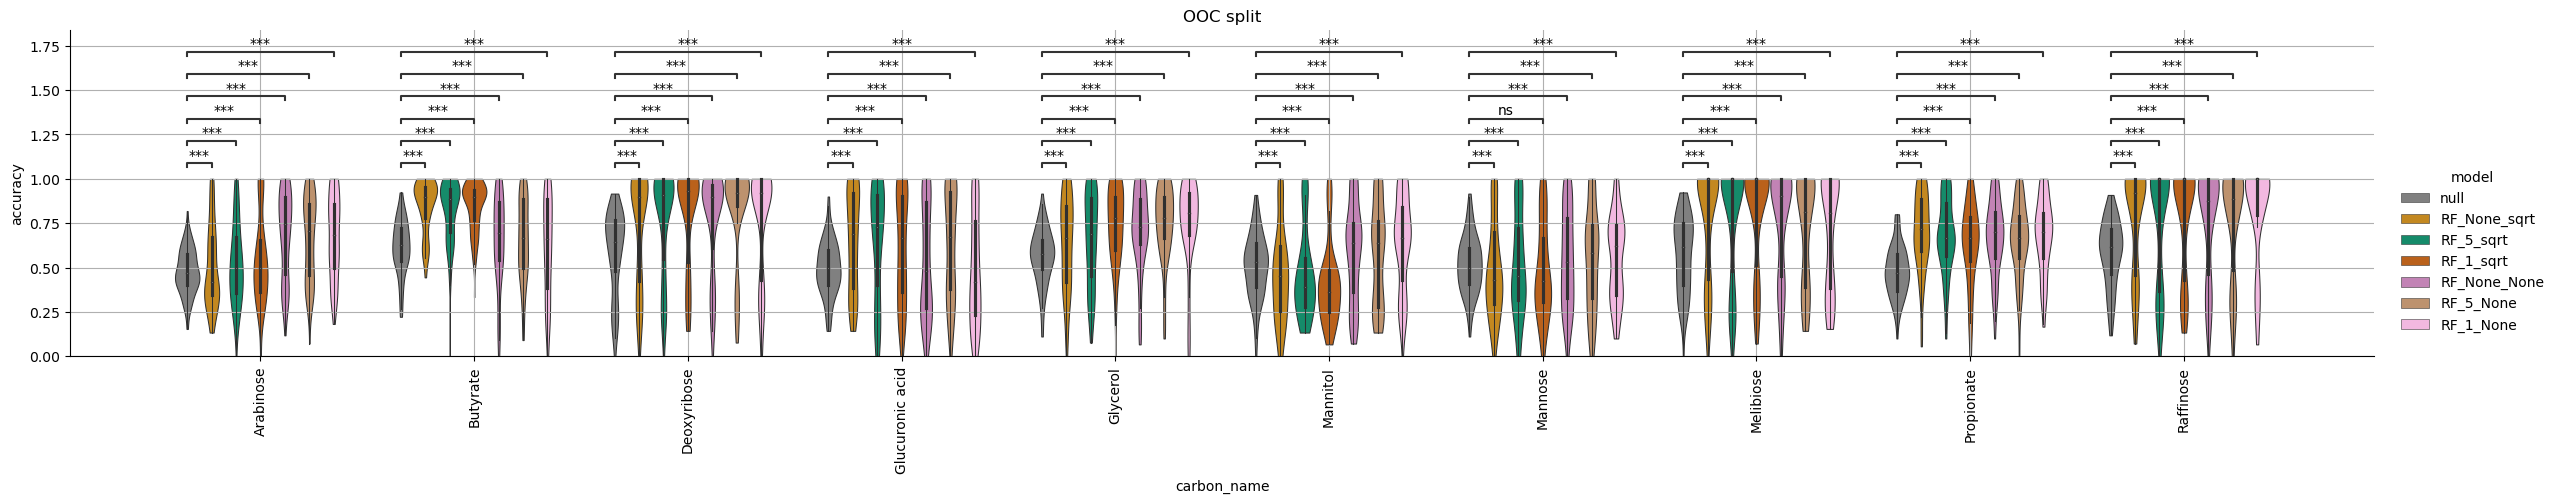

In [127]:
fig, stats=plot_fancy_model_comparison(df, hue_order=hue_order,stats=stats, model_pairs=model_pairs, multi_testing_correction=True, height=4, aspect=6)
fig.gca().set_title(f"OOC split")
fig

## Why RF fails

In [1]:
# 1. Acquire a random RF. Achieve this by training RF on X with shuffled gene labels (not shuffling each row independently).
# 2. For each split, for each sample in the test set, find its closet neighbor by L1 gene distance. Calculate the difference between RF's prediction on the test strain and its neighbor. 
# 3. Repeat for OOC split. 

In [3]:
DIR_figure="/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/rf_why_fails"

threads=1
models={ 'RF':[RF,
                {'model_params':{'n_estimators':100,'max_depth':None, 'max_features': None},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':True
                },
        ],
        'RF_ooc':[RF,
                {'model_params':{'n_estimators':100,'max_depth':None, 'max_features': None},
                'split_method':'ooc',   
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'save_models':True
                }],
    }

matrices={'zeqian': zeqian}

In [4]:
results_all=run_multiple_models(models, matrices, DIR_figure, 
                    p=None)

Running models...
Running zeqian RF
Already exists. Skipping. 
Running zeqian RF_ooc
Already exists. Skipping. 
Running models done.
Concatenating data...
Concatenating data done.


In [7]:
results_all=pd.read_pickle(f"{DIR_figure}/results_all.pk")
distances=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/figure_data/2C/zeqian_distance.pk")
gb=distances.groupby('s1')

def get_neighbors(test_sample, train_samples,metric='tree_distance'):
    group=gb.get_group(test_sample)[['s2',metric]]
    _idx=group.idxmin(numeric_only=True)[metric]
    return group.at[_idx,'s2']

n_bootstrap=100
results_all['train_prediction']=results_all.apply(lambda row: row['_model'].predict(zeqian['ko_data'].loc[row['train_samples'],:]),axis=1) # Prediction results on the training set
results_all['test_prediction']=results_all.apply(lambda row: row['_model'].predict(zeqian['ko_data'].loc[row['test_samples'],:]),axis=1) # Prediction results on the test set
for metric in ['tree_distance','genome_distance']:
    results_all['neighbor_'+metric]=results_all.apply(lambda row: [get_neighbors(s, row['train_samples'], metric=metric) for s in row['test_samples']], axis=1) # Get neighbors 
    results_all['neighbor_'+metric+'_prediction']=results_all.apply(lambda row: row['_model'].predict(zeqian['ko_data'].loc[row['neighbor_'+metric],:]),axis=1) # Prediction results on the neighbors
    results_all['test_neighbor_'+metric+'_diff']=results_all.apply(lambda row: np.abs(row['test_prediction']-row['neighbor_'+metric+'_prediction']).mean(),axis=1) # Comparing test/neighbor predictions
    results_all['null_test_neighbor_diff']=results_all.apply(lambda row: np.mean([np.abs(np.random.choice(row['train_prediction'],len(row['test_prediction']),replace=True)-row['test_prediction']).mean() for _ in range(n_bootstrap)]),axis=1) # Null: random strains in the training set 

results_all.to_pickle(f"{DIR_figure}/results_all.pk")

In [ ]:
results_all=pd.read_pickle(f"{DIR_figure}/results_all.pk")


In [20]:

dfs=[]
for key in ['test_neighbor_tree_distance_diff','test_neighbor_genome_distance_diff','null_test_neighbor_diff']:
    df=results_all[['carbon_name','model',key]].copy()
    df.rename(columns={key:'accuracy'},inplace=True)
    df['model']=df['model']+'_'+key
    dfs.append(df)

df=pd.concat(dfs,axis=0,ignore_index=True)

In [22]:
model_pairs=[('RF_test_neighbor_tree_distance_diff','RF_null_test_neighbor_diff'),('RF_ooc_test_neighbor_tree_distance_diff','RF_ooc_null_test_neighbor_diff')]
hue_order=['RF_test_neighbor_tree_distance_diff','RF_null_test_neighbor_diff','RF_ooc_test_neighbor_tree_distance_diff','RF_ooc_null_test_neighbor_diff']
stats=compare_models(df, 
                    model_pairs=[
                        (*model_pair, ttest_permutation) for model_pair in model_pairs
                    ],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy',
                    p_threshold=0.05,
                    multi_testing_correction=False).set_index('carbon_name')

100%|██████████| 10/10 [00:39<00:00,  3.92s/it]


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Deoxyribose_RF_ooc_test_neighbor_tree_distance_diff vs. Deoxyribose_RF_ooc_null_test_neighbor_diff: Custom statistical test with Bonferroni correction, P_val:2.000e-04
Glucuronic acid_RF_test_neighbor_tree_distance_diff vs. Glucuronic acid_RF_null_test_neighbor_diff: Custom statistical test with Bonferroni correction, P_val:2.000e-04
Glucuronic acid_RF_ooc_test_neighbor_tree_distance_diff vs. Glucuronic acid_RF_ooc_null_test_neighbor_diff: Custom statistical test with Bonferroni correction, P_val:2.000e-04
Glycerol_RF_test_neighbor_tree_distance_diff vs. Glycerol_RF_null_test_neighbor_diff: Custom statistical test with Bonferroni correction, P_val:2.000e-04
Butyrate_RF_ooc_test_neighbor_tree_distance_diff vs. Butyrate_RF_ooc_null_test_neighbor_diff: Custom statistical test with Bonferroni correction, P_val:2

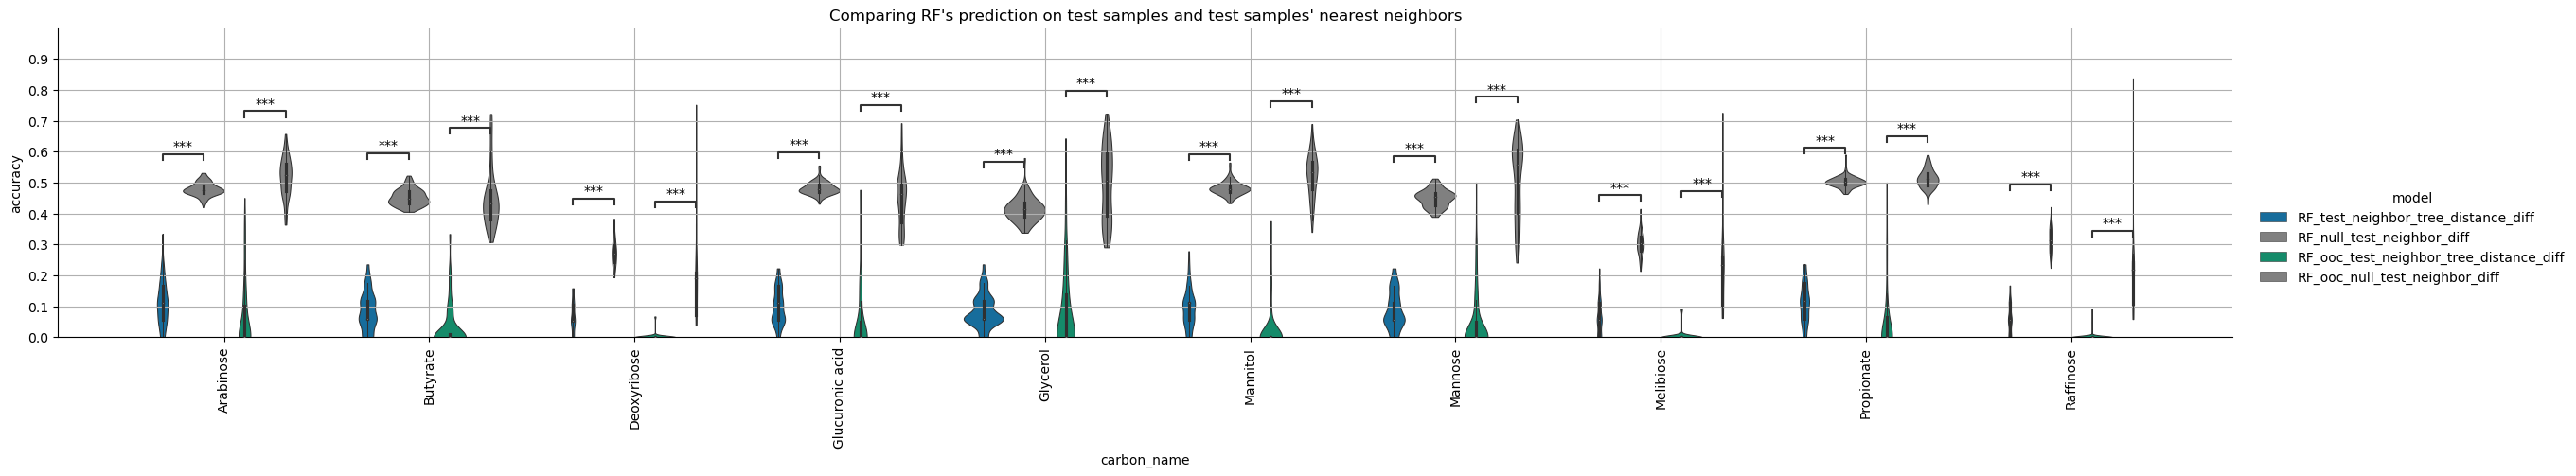

In [23]:
fig, stats=plot_fancy_model_comparison(df, hue_order=hue_order,stats=stats, model_pairs=model_pairs, multi_testing_correction=True, height=4, aspect=6)
fig.gca().set_title(f"Comparing RF's prediction on test samples and test samples' nearest neighbors")
plt.ylim(0,1)
fig

### Genome distance - tree distance correlation

In [24]:
distances=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/figure_data/2C/zeqian_distance.pk")


In [35]:
from scipy.stats import pearsonr
r,p=pearsonr(distances['genome_distance'],distances['tree_distance'])
print(r**2,p)

0.5969408950381556 0.0


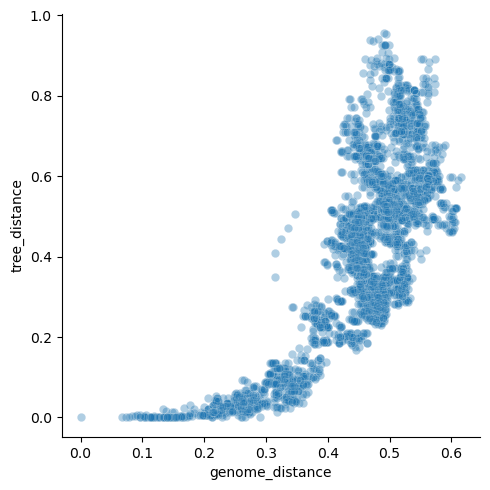

In [31]:
sns.scatterplot(data=distances, y='tree_distance', x='genome_distance',  alpha=0.1)
plt.gcf()

## Top features with high NCE

In [3]:
DIR_figure="/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/mutual_info"

In [4]:
import sklearn.metrics as metrics 
from scipy.stats import entropy

def mutual_info(arr1, arr2, signed=False):
    #return metrics.adjusted_mutual_info_score(arr1, arr2)
    if isinstance(arr1,list):
        arr1=np.array(arr1)
    if arr1.ndim!=1:
        arr1=(arr1 * np.array([[2**j for j in range(arr1.shape[1])] for i in range(arr1.shape[0])])).sum(axis=1) # binary coding 
    mi=metrics.mutual_info_score(arr1, arr2)
    if signed:
        mi=mi*np.sign(np.corrcoef(arr1, arr2)[0,1])
    return mi

def _entropy(arr):
    if np.all(arr==0) or np.all(arr==1):
        return 0
    else:
        return entropy(arr)

def neg_conditional_entropy(arr1, arr2):
    if isinstance(arr1,list):
        arr1=np.array(arr1)
    if arr1.ndim!=1:
        arr1=(arr1 * np.array([[2**j for j in range(arr1.shape[1])] for i in range(arr1.shape[0])])).sum(axis=1) # binary coding
    vs, counts = np.unique(arr1, return_counts=True)
    ce=0

    for v, count in zip(vs, counts):
        ce+=-count/len(arr1)*_entropy(arr2[arr1==v])    
    return ce

def _pickleable_cal_mi(key, explainer, y,metric):
    
    if metric=='mutual_info':
        f=mutual_info
    elif metric=='neg_conditional_entropy':
        f=neg_conditional_entropy
    else:
        raise ValueError(f"metric {metric} not recognized")
    mi=f(explainer, y)
    
    return key, mi

def get_top_features(X, y, keep_top=1,
            max_features=5, metric='mutual_info', verbose=False, trim=500,
            p=None):

    if keep_top!=1 and isinstance(keep_top, float):
        keep_top=int(keep_top*X.shape[1])
    features=X.columns
    if isinstance(y,pd.Series):
        y=y.values
    past_best=None
    df=[]
    
    _iter=range(1, max_features+1)
    if verbose:
        _iter=tqdm(_iter, desc="Number of features")
    for i in _iter:
        _batch=[]
        # _best=None
        for feature in features:
            if past_best is None:
                _batch.append(([feature], X[feature].values, y,metric))
            else:
                for past_features in past_best:
                    if not feature in past_features:
                        new_features=[*past_features, feature]
                        _batch.append((new_features,X[new_features].values, y, metric))
        if p is None:
            _res=[_pickleable_cal_mi(*args) for args in _batch]
        else:
            _res=p.starmap(_pickleable_cal_mi, _batch)
        
        _res=pd.DataFrame(_res, columns=["features", "metric"]).sort_values("metric", ascending=False)
        if trim:
            _res=_res.iloc[:trim, :]
        past_best=_res.iloc[:keep_top, :]['features'].values
        df.append(_res)
    df=pd.concat(df,axis=0,ignore_index=True)
    df['n_features']=df['features'].apply(lambda x: len(x))
    df=df.sort_values(['n_features',"metric"], ascending=[True,False])
    return df


In [5]:
p=Pool(48)

In [9]:
# Zeqian data 

metric='neg_conditional_entropy'
ko_data, growth_data,carbons=zeqian['ko_data'],zeqian['growth_data'],zeqian['carbons']

df_all=[]
for c in tqdm(carbons, desc="Carbon"):
    y=growth_data[c]
    _ind=y[y.notna()].index
    y=y.loc[_ind]
    X=ko_data.loc[_ind]

    df=get_top_features(X, y, max_features=5,keep_top=5,p=p,trim=500, metric=metric,verbose=False)
    df['carbon_name']=c
    df_all.append(df)

df_all=pd.concat(df_all,axis=0,ignore_index=True)
df_all.to_pickle(f"{DIR_figure}/zeqian_{metric}.pk")

Carbon: 100%|█████████████████████████████████████████████████████████████████████████████████████| 10/10 [07:46<00:00, 46.63s/it]


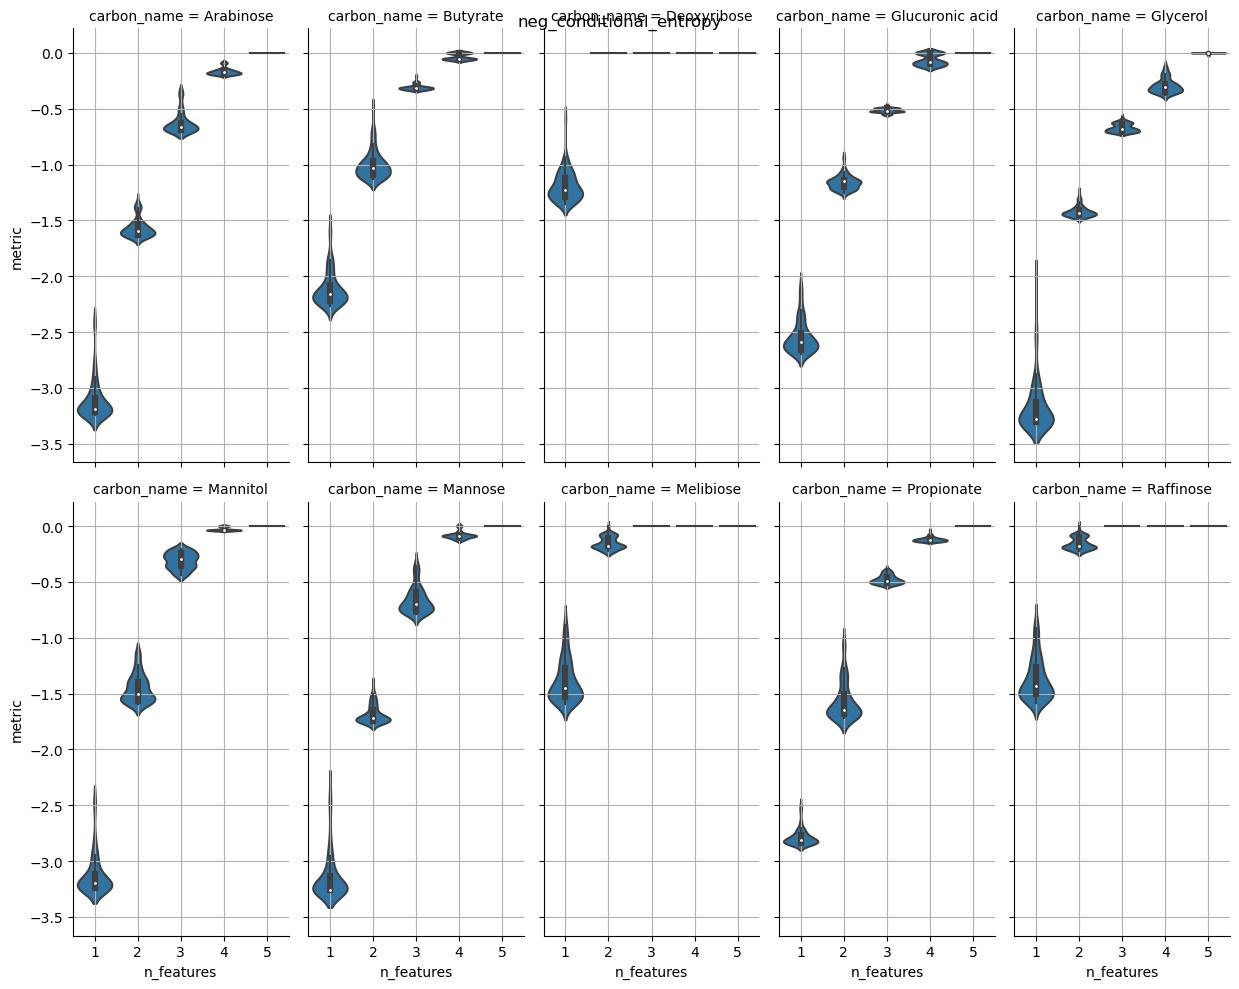

In [10]:
# Plot
metric='neg_conditional_entropy'

df_all=pd.read_pickle(f"{DIR_figure}/zeqian_{metric}.pk")
df_all=df_all.sort_values(by=['carbon_name','n_features','metric'], ascending=[True,True,False])
df_all['_dummy']=1
df_top=df_all.groupby(['carbon_name','n_features']).head(100)
sns.catplot(data=df_top, x="n_features", y="metric", col="carbon_name", hue='_dummy',aspect=.5,kind='violin',col_wrap=5,legend=False)

for ax in plt.gcf().axes:
    #ax.set_ylim(-0.1,1.1)
    ax.grid()
fig=plt.gcf()
fig.suptitle(metric)
fig


## Negative conditional entropy feature selection

In [3]:
DIR_figure=f"{DIR_SI_figure_data}/nce"

In [ ]:
threads=48
p=None
# p=Pool(threads)

In [ ]:


models={'null_ooc': [BernoulliNull,
                {'model_params':{},
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                 'n_splits':100,
                 'threads': threads,
                 'save_models':True
                 }],
        'nce_fs_ooc':[NCEFeatureSelection,
                {'model_params':{
                    "Model":RF, 
                    "model_params":{'n_estimators':100,'max_features':None},
                    "keep_top": 5,
                    "max_features":5, 
                    "n_feature_subsample":None,
                    "threads":threads, 'p':p,               
                    "save_feature_selection_data":100,
                    'verbose':False, 
                    },
                'split_method':'ooc',
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads':1,
                'p': None,
                'save_models':True,
                }]
}

matrices={ 'zeqian': zeqian}


In [ ]:
results_all=run_multiple_models(models, matrices, DIR_figure, p=p)

Running models...
Running zeqian null_ooc
Already exists. Skipping. 
Running zeqian nce_fs_ooc
Changed to /home/zeqianli/project/zeqian/Carbon/data/figure_data/nce/cache/zeqian_nce_fs_ooc_0.pk. 


Training models...: 100%|██████████████████████████████████████████████████████████████████| 1000/1000 [12:56:26<00:00, 46.59s/it]


Finished zeqian nce_fs_ooc 
Running models done.
Concatenating data...
Concatenating data done.


In [4]:
results_all=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/nce/results_all.pk")

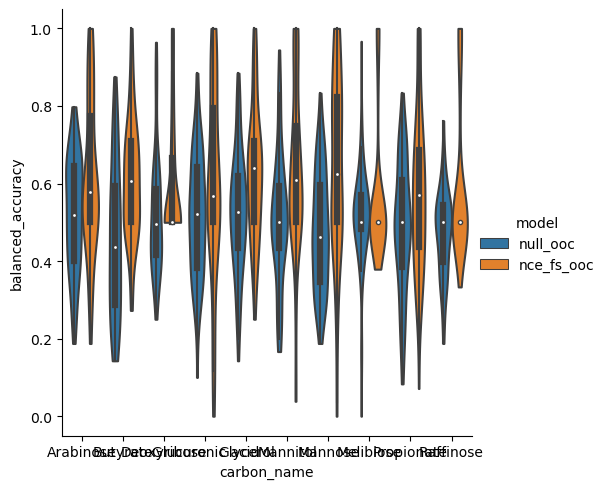

In [9]:
# Quick visualization
sns.catplot(data=results_all, x='carbon_name',y='balanced_accuracy',cut=0,hue='model',kind='violin')

In [9]:
all_feature_selection_data=[]

for _, row in tqdm(results_all[results_all['model']=='nce_fs_ooc'].iterrows()):
    df=row['_model']._feature_selection_data.copy()
    for k, v in row.items():
        if k in ['carbon_name','train_samples','test_samples','final_features','final_features_nce']:
            df[k]=[v]*df.shape[0]
    all_feature_selection_data.append(df)

all_feature_selection_data=pd.concat(all_feature_selection_data,axis=0,ignore_index=True)

1000it [00:01, 816.56it/s]


In [11]:
rf_params={'n_estimators':100,'max_features':None}

def train_test_RF(row):
    X_train=zeqian['ko_data'].loc[row['train_samples'], row['features']].values
    y_train=zeqian['growth_data'].loc[row['train_samples'],row['carbon_name']].values
    X_test=zeqian['ko_data'].loc[row['test_samples'], row['features']].values
    y_test=zeqian['growth_data'].loc[row['test_samples'],row['carbon_name']].values
    out=row.to_dict()
    rf=RF(**rf_params)
    rf.fit(X_train,y_train)
    out.update(rf.score(X_test,y_test))
    return out

In [12]:
p=Pool(48)

In [14]:
batch_size=48*10
_batch=[]
split_rf_nce=[]
for _, row in tqdm(all_feature_selection_data.iterrows(), total=all_feature_selection_data.shape[0]):
    _batch.append(row)
    if len(_batch)>=batch_size:
        split_rf_nce.extend(p.map(train_test_RF, _batch))
        _batch=[]
if _batch:
    split_rf_nce.extend(p.map(train_test_RF, _batch))
    _batch=[]

df=pd.DataFrame(split_rf_nce)
df.to_pickle(f"{DIR_SI_figure_data}/nce/zeqian_split_nce_rf.pk")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [20:52<00:00, 399.25it/s]


In [4]:
fs_data=pd.read_pickle(f"{DIR_SI_figure_data}/nce/zeqian_split_nce_rf.pk")
fs_data['test_samples_str']=fs_data['test_samples'].apply(lambda x: ','.join(x))


# df_all['features_str']=df_all['features'].map(lambda x: ','.join(np.sort(x)))
# min_metric_value=df_all['train_metric'].min()
# n_split=df_all['i_split'].max()+1

# def mean_metric(group):
#     return {'train_metric_mean': (group['train_metric'].sum()+min_metric_value*max((n_split-group.shape[0]),0))/max(group.shape[0],n_split),
#             'test_accuracy_mean': group['accuracy'].mean()}

# df_mean=[]
# for (carbon_name, split, n_featurs, features_str),group in df_all.groupby(['carbon_name','split','n_features','features_str']):
#     out={'carbon_name':carbon_name,'split':split,'n_features':n_featurs,'features_str':features_str}
#     out.update(mean_metric(group))
#     df_mean.append(out)

# df_mean=pd.DataFrame(df_mean)
# # N_top=100
# df_mean=df_mean.sort_values(by=['carbon_name','split','n_features','train_metric_mean'], ascending=[True,True,True,False])

# df_mean=df_mean.groupby(['carbon_name','split','n_features']).head(N_top)

# df_mean.merge(df_all, on=['carbon_name','split','n_features','features_str'], how='left')

In [9]:
fs_data

,features,nce,n_features,features_str,carbon_name,train_samples,test_samples,final_features,final_features_nce,true_negative,false_positive,false_negative,true_positive,accuracy,precision,sensitivity,specificity,f1_score,balanced_accuracy,test_samples_str
0,[K10439],-2.559354,1,K10439,Arabinose,"[HMWF001, HMWF003, HMWF005, HMWF006, HMWF010, ...","[HMWF008, HMWF009, HMWF022, HMWF023, HMWF025, ...","[K23509, K21470, K06211, K07486, K00001]","[-2.627761825598046, -1.514303424920908, -0.26...",5,0,0,13,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,"HMWF008,HMWF009,HMWF022,HMWF023,HMWF025,OTU397..."
1,[K23509],-2.627762,1,K23509,Arabinose,"[HMWF001, HMWF003, HMWF005, HMWF006, HMWF010, ...","[HMWF008, HMWF009, HMWF022, HMWF023, HMWF025, ...","[K23509, K21470, K06211, K07486, K00001]","[-2.627761825598046, -1.514303424920908, -0.26...",5,0,2,11,0.888889,1.0,0.846154,1.000000,0.916667,0.923077,"HMWF008,HMWF009,HMWF022,HMWF023,HMWF025,OTU397..."
2,[K23508],-2.627762,1,K23508,Arabinose,"[HMWF001, HMWF003, HMWF005, HMWF006, HMWF010, ...","[HMWF008, HMWF009, HMWF022, HMWF023, HMWF025, ...","[K23509, K21470, K06211, K07486, K00001]","[-2.627761825598046, -1.514303424920908, -0.26...",5,0,2,11,0.888889,1.0,0.846154,1.000000,0.916667,0.923077,"HMWF008,HMWF009,HMWF022,HMWF023,HMWF025,OTU397..."
3,[K10820],-2.627762,1,K10820,Arabinose,"[HMWF001, HMWF003, HMWF005, HMWF006, HMWF010, ...","[HMWF008, HMWF009, HMWF022, HMWF023, HMWF025, ...","[K23509, K21470, K06211, K07486, K00001]","[-2.627761825598046, -1.514303424920908, -0.26...",5,0,2,11,0.888889,1.0,0.846154,1.000000,0.916667,0.923077,"HMWF008,HMWF009,HMWF022,HMWF023,HMWF025,OTU397..."
4,[K00241],-2.627762,1,K00241,Arabinose,"[HMWF001, HMWF003, HMWF005, HMWF006, HMWF010, ...","[HMWF008, HMWF009, HMWF022, HMWF023, HMWF025, ...","[K23509, K21470, K06211, K07486, K00001]","[-2.627761825598046, -1.514303424920908, -0.26...",2,3,13,0,0.111111,0.0,0.000000,0.400000,NaN,0.200000,"HMWF008,HMWF009,HMWF022,HMWF023,HMWF025,OTU397..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,"[K18334, K00196, K12282, K12281, K12248]",0.000000,5,"K18334,K00196,K12282,K12281,K12248",Raffinose,"[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...","[HMWF018, HMWF029, OTU2469, OTU3427, sic0104, ...","[K18334, K18673, K12282, K12283, K00001]","[-0.8673254910537708, 0.0, 0.0, 0.0, 0.0]",16,2,0,0,0.888889,0.0,NaN,0.888889,NaN,NaN,"HMWF018,HMWF029,OTU2469,OTU3427,sic0104,sic060..."
499996,"[K18334, K00196, K00001, K12282, K12248]",0.000000,5,"K18334,K00196,K00001,K12282,K12248",Raffinose,"[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...","[HMWF018, HMWF029, OTU2469, OTU3427, sic0104, ...","[K18334, K18673, K12282, K12283, K00001]","[-0.8673254910537708, 0.0, 0.0, 0.0, 0.0]",16,2,0,0,0.888889,0.0,NaN,0.888889,NaN,NaN,"HMWF018,HMWF029,OTU2469,OTU3427,sic0104,sic060..."
499997,"[K18334, K18673, K12282, K12283, K12256]",0.000000,5,"K18334,K18673,K12282,K12283,K12256",Raffinose,"[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...","[HMWF018, HMWF029, OTU2469, OTU3427, sic0104, ...","[K18334, K18673, K12282, K12283, K00001]","[-0.8673254910537708, 0.0, 0.0, 0.0, 0.0]",17,1,0,0,0.944444,0.0,NaN,0.944444,NaN,NaN,"HMWF018,HMWF029,OTU2469,OTU3427,sic0104,sic060..."
499998,"[K18334, K00196, K12282, K12281, K12256]",0.000000,5,"K18334,K00196,K12282,K12281,K12256",Raffinose,"[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...","[HMWF018, HMWF029, OTU2469, OTU3427, sic0104, ...","[K18334, K18673, K12282, K12283, K00001]","[-0.8673254910537708, 0.0, 0.0, 0.0, 0.0]",16,2,0,0,0.888889,0.0,NaN,0.888889,NaN,NaN,"HMWF018,HMWF029,OTU2469,OTU3427,sic0104,sic060..."


In [14]:
fs_data=fs_data.sort_values(['carbon_name','n_features','test_samples_str','nce'], ascending=[True,True,True,False])
fs_data=fs_data.groupby(['carbon_name','n_features','test_samples_str']).head(100)
fs_data['features_rank']=fs_data.groupby(['carbon_name','n_features','test_samples_str'])['nce'].rank(ascending=False,method='first').astype(int)

In [16]:
fs_mean=fs_data.groupby(['carbon_name','n_features','features_rank'])[['nce','accuracy']].mean().reset_index()

In [20]:
fs_data[(fs_data['carbon_name']=='Deoxyribose') & (fs_data['n_features']==100)]

,features,nce,n_features,features_str,carbon_name,train_samples,test_samples,final_features,final_features_nce,true_negative,false_positive,false_negative,true_positive,accuracy,precision,sensitivity,specificity,f1_score,balanced_accuracy,test_samples_str,features_rank
136500,[K00875],-0.564787,1,K00875,Deoxyribose,"[HMWF005, HMWF006, HMWF008, HMWF009, HMWF010, ...","[HMWF001, HMWF003, HMWF013, HMWF019, HMWF022, ...","[K00875, K00246, K12283, K12284, K00001]","[-0.5647865915673628, 0.0, 0.0, 0.0, 0.0]",14,0,0,0,1.000000,NaN,NaN,1.000000,NaN,NaN,"HMWF001,HMWF003,HMWF013,HMWF019,HMWF022,HMWF02...",1
136501,[K23541],-0.855737,1,K23541,Deoxyribose,"[HMWF005, HMWF006, HMWF008, HMWF009, HMWF010, ...","[HMWF001, HMWF003, HMWF013, HMWF019, HMWF022, ...","[K00875, K00246, K12283, K12284, K00001]","[-0.5647865915673628, 0.0, 0.0, 0.0, 0.0]",3,11,0,0,0.214286,0.0,NaN,0.214286,NaN,NaN,"HMWF001,HMWF003,HMWF013,HMWF019,HMWF022,HMWF02...",2
136502,[K09792],-0.889967,1,K09792,Deoxyribose,"[HMWF005, HMWF006, HMWF008, HMWF009, HMWF010, ...","[HMWF001, HMWF003, HMWF013, HMWF019, HMWF022, ...","[K00875, K00246, K12283, K12284, K00001]","[-0.5647865915673628, 0.0, 0.0, 0.0, 0.0]",7,7,0,0,0.500000,0.0,NaN,0.500000,NaN,NaN,"HMWF001,HMWF003,HMWF013,HMWF019,HMWF022,HMWF02...",3
136503,[K21621],-0.908729,1,K21621,Deoxyribose,"[HMWF005, HMWF006, HMWF008, HMWF009, HMWF010, ...","[HMWF001, HMWF003, HMWF013, HMWF019, HMWF022, ...","[K00875, K00246, K12283, K12284, K00001]","[-0.5647865915673628, 0.0, 0.0, 0.0, 0.0]",14,0,0,0,1.000000,NaN,NaN,1.000000,NaN,NaN,"HMWF001,HMWF003,HMWF013,HMWF019,HMWF022,HMWF02...",4
136504,[K02664],-0.958426,1,K02664,Deoxyribose,"[HMWF005, HMWF006, HMWF008, HMWF009, HMWF010, ...","[HMWF001, HMWF003, HMWF013, HMWF019, HMWF022, ...","[K00875, K00246, K12283, K12284, K00001]","[-0.5647865915673628, 0.0, 0.0, 0.0, 0.0]",7,7,0,0,0.500000,0.0,NaN,0.500000,NaN,NaN,"HMWF001,HMWF003,HMWF013,HMWF019,HMWF022,HMWF02...",5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114495,"[K00875, K10119, K12283, K00001, K12252]",0.000000,5,"K00875,K10119,K12283,K00001,K12252",Deoxyribose,"[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...","[OTU736, sib0205, sib0404, sic0204, sid0901, s...","[K00875, K10108, K12283, K12282, K00001]","[0.0, 0.0, 0.0, 0.0, 0.0]",7,0,1,2,0.900000,1.0,0.666667,1.000000,0.8,0.833333,"OTU736,sib0205,sib0404,sic0204,sid0901,sif0532...",96
114496,"[K00875, K10108, K12283, K12282, K12251]",0.000000,5,"K00875,K10108,K12283,K12282,K12251",Deoxyribose,"[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...","[OTU736, sib0205, sib0404, sic0204, sid0901, s...","[K00875, K10108, K12283, K12282, K00001]","[0.0, 0.0, 0.0, 0.0, 0.0]",7,0,1,2,0.900000,1.0,0.666667,1.000000,0.8,0.833333,"OTU736,sib0205,sib0404,sic0204,sid0901,sif0532...",97
114497,"[K21621, K00001, K12283, K12282, K12257]",0.000000,5,"K21621,K00001,K12283,K12282,K12257",Deoxyribose,"[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...","[OTU736, sib0205, sib0404, sic0204, sid0901, s...","[K00875, K10108, K12283, K12282, K00001]","[0.0, 0.0, 0.0, 0.0, 0.0]",7,0,3,0,0.700000,NaN,0.000000,1.000000,NaN,0.500000,"OTU736,sib0205,sib0404,sic0204,sid0901,sif0532...",98
114498,"[K00875, K10119, K12283, K00001, K12260]",0.000000,5,"K00875,K10119,K12283,K00001,K12260",Deoxyribose,"[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...","[OTU736, sib0205, sib0404, sic0204, sid0901, s...","[K00875, K10108, K12283, K12282, K00001]","[0.0, 0.0, 0.0, 0.0, 0.0]",7,0,1,2,0.900000,1.0,0.666667,1.000000,0.8,0.833333,"OTU736,sib0205,sib0404,sic0204,sid0901,sif0532...",99


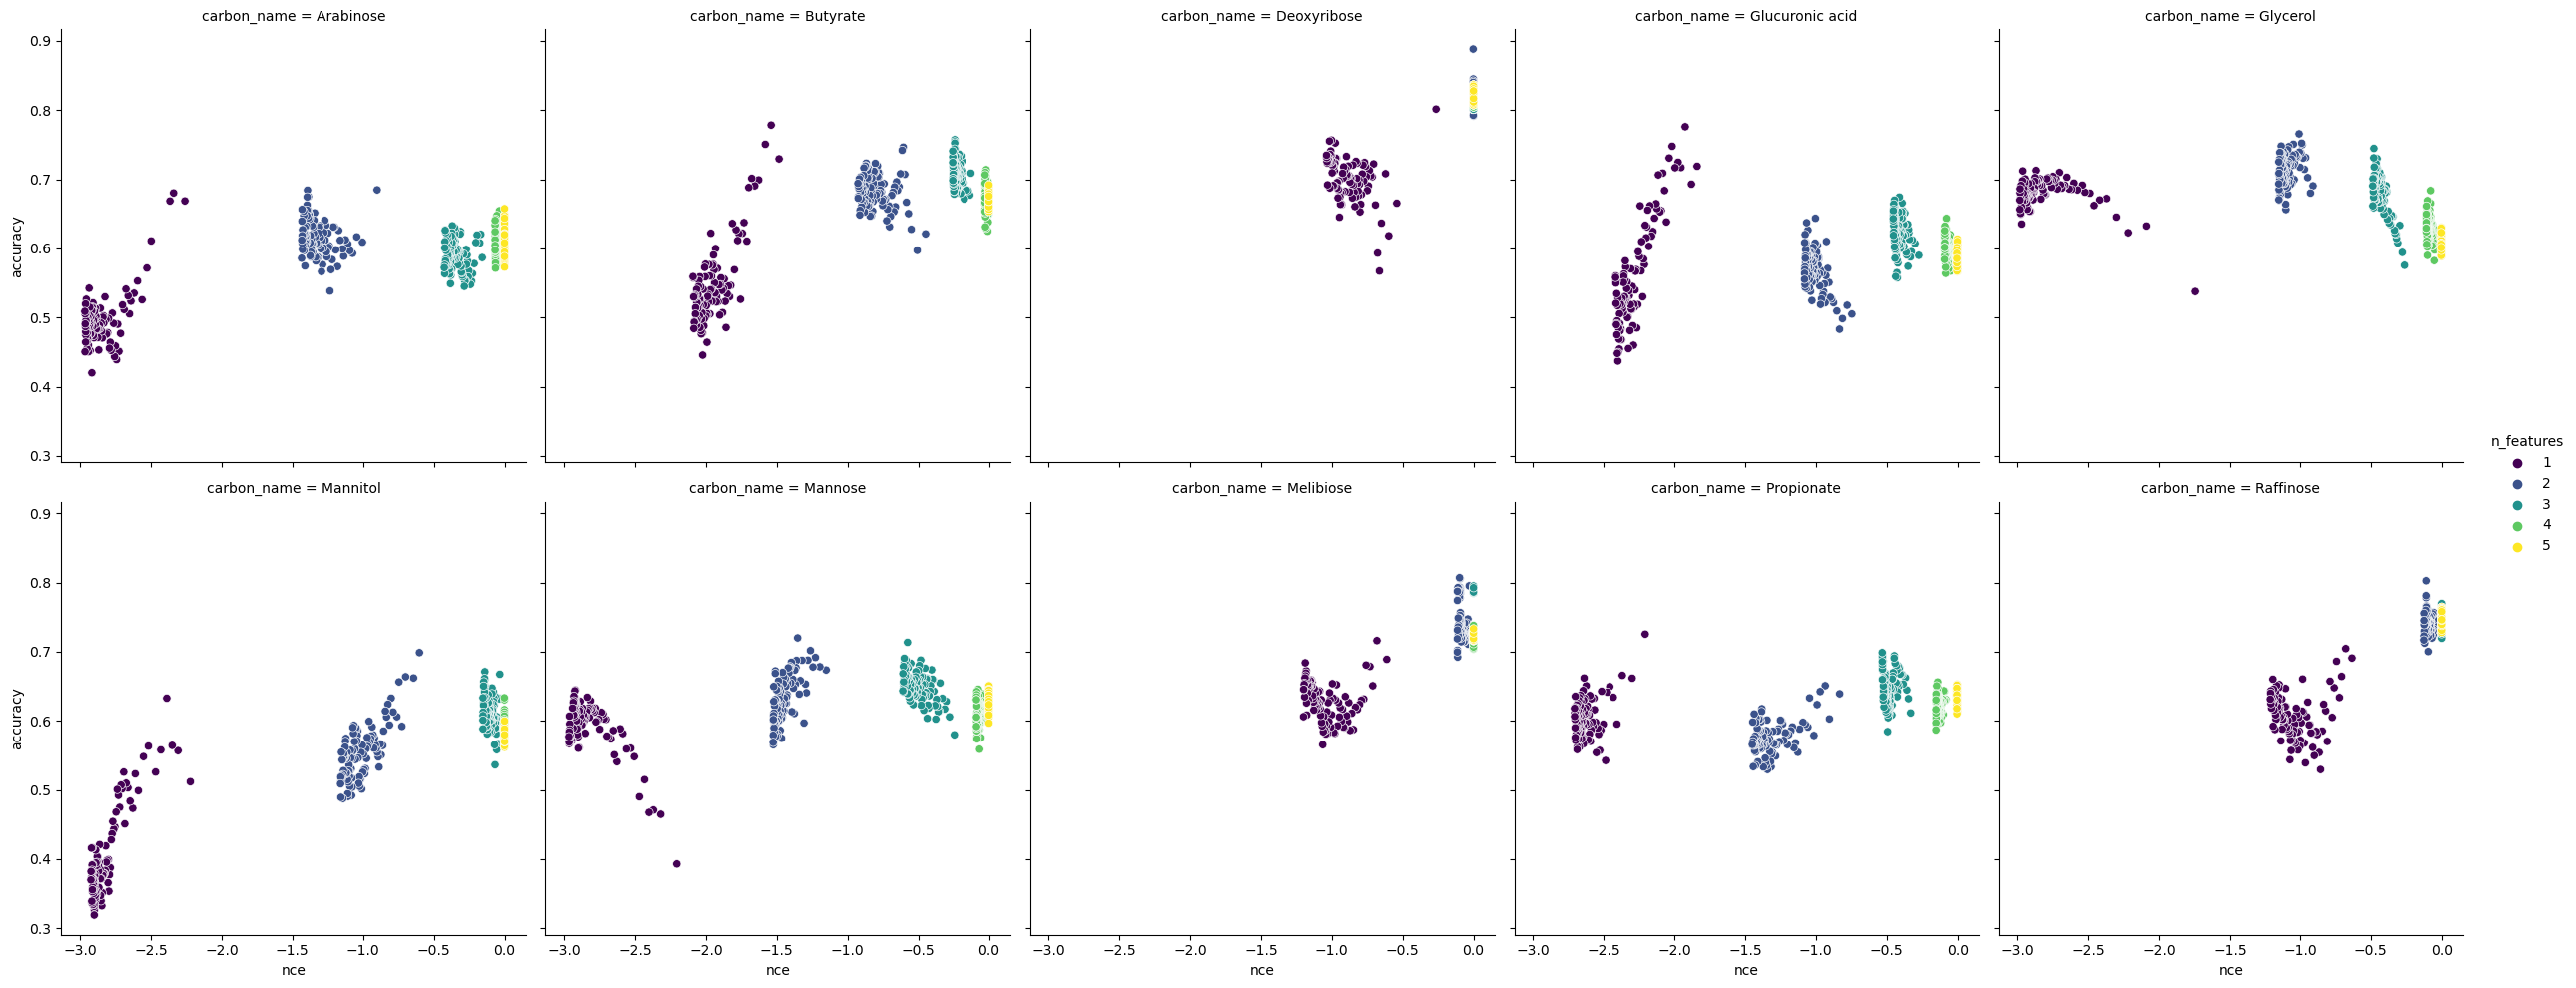

In [18]:
sns.relplot(data=fs_mean, x='nce',y='accuracy',hue='n_features',kind='scatter',col='carbon_name',col_wrap=5,palette='viridis')

In [11]:
fs_data

,features,nce,n_features,features_str,carbon_name,train_samples,test_samples,final_features,final_features_nce,true_negative,false_positive,false_negative,true_positive,accuracy,precision,sensitivity,specificity,f1_score,balanced_accuracy,test_samples_str
9500,[K06726],-2.242604,1,K06726,Arabinose,"[HMWF003, HMWF005, HMWF006, HMWF010, HMWF014, ...","[HMWF001, HMWF008, HMWF009, HMWF013, HMWF018, ...","[K06726, K03427, K06211, K22294, K00001]","[-2.2426041618625527, -0.8120176398816179, -0....",8,0,16,3,0.407407,1.000000,0.157895,1.000,0.272727,0.578947,"HMWF001,HMWF008,HMWF009,HMWF013,HMWF018,HMWF01..."
9501,[K10439],-2.425767,1,K10439,Arabinose,"[HMWF003, HMWF005, HMWF006, HMWF010, HMWF014, ...","[HMWF001, HMWF008, HMWF009, HMWF013, HMWF018, ...","[K06726, K03427, K06211, K22294, K00001]","[-2.2426041618625527, -0.8120176398816179, -0....",6,2,1,18,0.888889,0.900000,0.947368,0.750,0.923077,0.848684,"HMWF001,HMWF008,HMWF009,HMWF013,HMWF018,HMWF01..."
9502,[K01303],-2.570790,1,K01303,Arabinose,"[HMWF003, HMWF005, HMWF006, HMWF010, HMWF014, ...","[HMWF001, HMWF008, HMWF009, HMWF013, HMWF018, ...","[K06726, K03427, K06211, K22294, K00001]","[-2.2426041618625527, -0.8120176398816179, -0....",6,2,2,17,0.851852,0.894737,0.894737,0.750,0.894737,0.822368,"HMWF001,HMWF008,HMWF009,HMWF013,HMWF018,HMWF01..."
9503,[K04343],-2.570790,1,K04343,Arabinose,"[HMWF003, HMWF005, HMWF006, HMWF010, HMWF014, ...","[HMWF001, HMWF008, HMWF009, HMWF013, HMWF018, ...","[K06726, K03427, K06211, K22294, K00001]","[-2.2426041618625527, -0.8120176398816179, -0....",1,7,12,7,0.296296,0.500000,0.368421,0.125,0.424242,0.246711,"HMWF001,HMWF008,HMWF009,HMWF013,HMWF018,HMWF01..."
9504,[K22350],-2.591336,1,K22350,Arabinose,"[HMWF003, HMWF005, HMWF006, HMWF010, HMWF014, ...","[HMWF001, HMWF008, HMWF009, HMWF013, HMWF018, ...","[K06726, K03427, K06211, K22294, K00001]","[-2.2426041618625527, -0.8120176398816179, -0....",8,0,19,0,0.296296,NaN,0.000000,1.000,NaN,0.500000,"HMWF001,HMWF008,HMWF009,HMWF013,HMWF018,HMWF01..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487995,"[K25182, K02455, K08683, K12282, K12251]",0.000000,5,"K25182,K02455,K08683,K12282,K12251",Raffinose,"[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...","[OTU736, sia0102, sia0703, sia0901, sia0902, s...","[K25182, K02455, K02011, K12283, K00001]","[-0.9464268147320701, 0.0, 0.0, 0.0, 0.0]",10,0,0,0,1.000000,NaN,NaN,1.000,NaN,NaN,"OTU736,sia0102,sia0703,sia0901,sia0902,sib0112..."
487996,"[K25182, K02455, K02010, K12282, K12251]",0.000000,5,"K25182,K02455,K02010,K12282,K12251",Raffinose,"[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...","[OTU736, sia0102, sia0703, sia0901, sia0902, s...","[K25182, K02455, K02011, K12283, K00001]","[-0.9464268147320701, 0.0, 0.0, 0.0, 0.0]",10,0,0,0,1.000000,NaN,NaN,1.000,NaN,NaN,"OTU736,sia0102,sia0703,sia0901,sia0902,sib0112..."
487997,"[K25182, K02455, K00001, K12283, K12257]",0.000000,5,"K25182,K02455,K00001,K12283,K12257",Raffinose,"[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...","[OTU736, sia0102, sia0703, sia0901, sia0902, s...","[K25182, K02455, K02011, K12283, K00001]","[-0.9464268147320701, 0.0, 0.0, 0.0, 0.0]",10,0,0,0,1.000000,NaN,NaN,1.000,NaN,NaN,"OTU736,sia0102,sia0703,sia0901,sia0902,sib0112..."
487998,"[K25182, K02455, K08683, K12282, K12257]",0.000000,5,"K25182,K02455,K08683,K12282,K12257",Raffinose,"[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...","[OTU736, sia0102, sia0703, sia0901, sia0902, s...","[K25182, K02455, K02011, K12283, K00001]","[-0.9464268147320701, 0.0, 0.0, 0.0, 0.0]",10,0,0,0,1.000000,NaN,NaN,1.000,NaN,NaN,"OTU736,sia0102,sia0703,sia0901,sia0902,sib0112..."


In [ ]:
df_mean=df_mean.sort_values(by=['carbon_name','split','n_features','train_metric_mean'], ascending=[True,True,True,False])


# Figure 4

## Denitrification

### Organize data

In [9]:
DIR_figure=f"{DIR_SI_figure_data}/denitrification"

In [12]:
# Process phenotype data
dn=pd.read_csv(f"{DIR_figure}/raw/strain_list.csv")
dn_lookup=pd.read_excel(f"{DIR_figure}/raw/karna_strain_relabel_lookup.xlsx",header=None,names=['sample','Strain'])
dn=dn.merge(dn_lookup,on='Strain',how='left')
dn['nar']=dn['Phenotype'].str.contains('NAR').astype(int)
dn['nir']=dn['Phenotype'].str.contains('NIR').astype(int)
dn=dn[['sample','nar','nir']].set_index('sample')
dn.to_csv(f"{DIR_figure}/dn_phenotype.csv")


In [18]:
# Finalize
zeqian=pd.read_pickle(f"{DIR_data}/zeqian/zeqian.pk")
dn=pd.read_csv(f"{DIR_figure}/dn_phenotype.csv",index_col=0)
zeqian_dn=finalize_data(zeqian['ko_data'],dn, zeqian['tree'], remove_prefix=True)
with open(f"{DIR_figure}/zeqian_dn.pk",'wb') as f:
    pickle.dump(zeqian_dn, f)


54 samples:  ['pd19367' 'sia0102' 'sia0703' 'sia0901' 'sia0902' 'sib0112' 'sib0115'
 'sib0205' 'sib0402' 'sib0404' 'sib0509' 'sib0612' 'sic0102' 'sic0105'
 'sic0204' 'sic0404' 'sic0604' 'sic0702' 'sic1001' 'sic1004' 'sic1005'
 'sic1102' 'sic1205' 'sic1506' 'sid0104' 'sid0204' 'sid0306' 'sid0307'
 'sid0404' 'sid0406' 'sid0505' 'sid0601' 'sid0605' 'sid0705' 'sid0801'
 'sid0901' 'sid1001' 'sid1006' 'sie0102' 'sie1401' 'sie1917' 'sif0513'
 'sif0514' 'sif0532' 'sif0617' 'sif0631' 'sif1732' 'sif1831' 'sif1833'
 'sif2231' 'sif2232' 'sif2233' 'sif2332' 'sif2431']


In [71]:
DN_GENES=pd.DataFrame(
         [("narG",      "K00370",   1),
          ("napA",      "K02567",   1),
          ("nirS",      "K15864",   2),
          ("nirK",      "K00368",   2),
          ("qNor",      "K04561",   3),
          ("nosZ",      "K00376",   4),
          ("narX",      "K07673",   5),
          ("dnr",       "K21563",   5),
          ("nnrR",      "K21564",   5),
          ("norR",      "K12266",   5),
          ("nnrS",      "K07234",   5),
          ("nsrR",      "K13771",   5),
          ("narK",     "K02575",   6)], 
          columns=['name','ko','group'])
DN_GENES.index=DN_GENES['ko'].values



### Plot matrices

In [72]:
DN_GENES

,name,ko,group
K00370,narG,K00370,1
K02567,napA,K02567,1
K15864,nirS,K15864,2
K00368,nirK,K00368,2
K04561,qNor,K04561,3
K00376,nosZ,K00376,4
K07673,narX,K07673,5
K21563,dnr,K21563,5
K21564,nnrR,K21564,5
K12266,norR,K12266,5


In [76]:
fig,axes=plt.subplots(1,2, figsize=(10,15), sharey=True, gridspec_kw={'width_ratios':[4,1]})


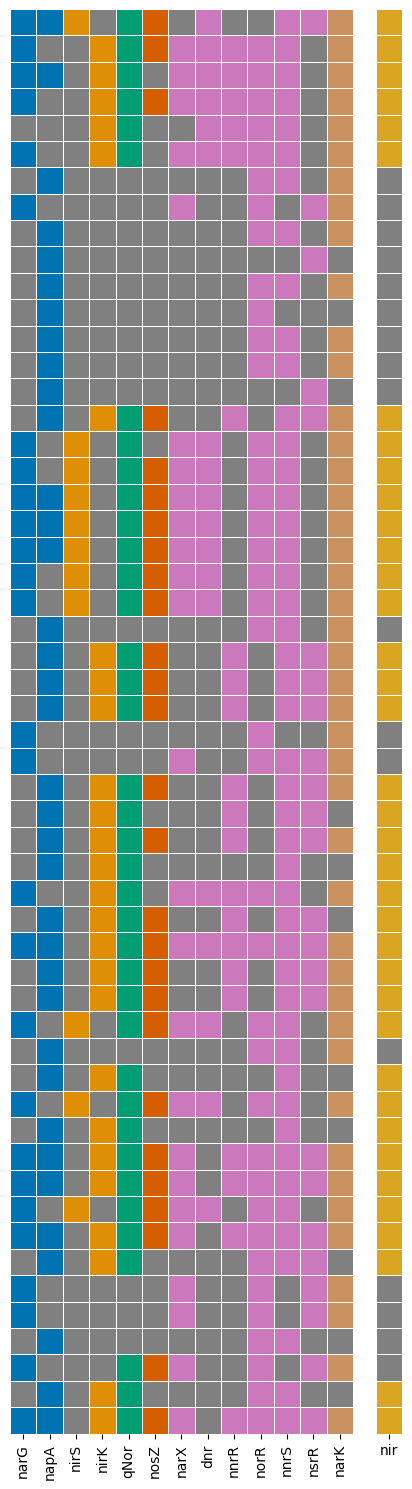

In [89]:
zeqian_dn=pd.read_pickle(f"{DIR_figure}/zeqian_dn.pk")
colors=sns.color_palette('colorblind', DN_GENES['group'].nunique())
colors=['grey',*colors]


_kos=[ko for ko in DN_GENES['ko'] if ko in zeqian_dn['ko_data'].columns]
ko_matrix=zeqian_dn['ko_data'].loc[:,_kos].copy()

for ko in ko_matrix.columns:
    ko_matrix[ko]=(ko_matrix[ko]*(DN_GENES.at[ko,'group'])).values
ko_matrix.columns=[DN_GENES.at[ko,'name'] for ko in ko_matrix.columns]

sns.heatmap(data=ko_matrix, ax=axes[0], cmap=colors, cbar=False, linewidths=0.5, linecolor='white', square=True)

sns.heatmap(data=zeqian_dn['growth_data'][['nir']],ax=axes[1],cmap=['grey','goldenrod'],cbar=False, square=True, linewidths=0.5, linecolor='white',yticklabels=False)

axes[1].set_ylabel(None)


fig.tight_layout()

plt.gcf()


In [61]:
(ko_matrix['K00370']*5).shape

(54,)

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), (0.8352941176470589, 0.3686274509803922, 0.0), (0.8, 0.47058823529411764, 0.7372549019607844), (0.792156862745098, 0.5686274509803921, 0.3803921568627451)]


### Prediction models 

In [27]:
threads=1
zeqian_dn=pd.read_pickle(f"{DIR_figure}/zeqian_dn.pk")

models={'null': [BernoulliNull,
                {'model_params':{},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }],
        'null_ooc': [BernoulliNull,
                {'model_params':{},
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }],
                
        'NN':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }
              ],
        'NN_ooc':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'ooc',
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'save_models':False
                }
                ],
        'RF':[RF,
                {'model_params':{'n_estimators':100,'max_depth':None, 'max_features': 'sqrt'},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                },
        ],
        'RF_None':[RF,
                {'model_params':{'n_estimators':100,'max_depth':None, 'max_features': None},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                },
        ],
        'RF_ooc':[RF,
                {'model_params':{'n_estimators':100,'max_depth':None, 'max_features': 'sqrt'},
                'split_method':'ooc',   
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'save_models':False
                }],
        'RF_None_ooc':[RF,
                {'model_params':{'n_estimators':100,'max_depth':None, 'max_features': None},
                'split_method':'ooc',   
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'save_models':False
                }],
        'RF_1_ooc':[RF,
                {'model_params':{'n_estimators':100,'max_depth':1, 'max_features': None},
                'split_method':'ooc',   
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'save_models':False
                }],
        'RF_5_ooc':[RF,
                {'model_params':{'n_estimators':100,'max_depth':5, 'max_features': None},
                'split_method':'ooc',   
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'save_models':False
                }],
}

matrices={
          'zeqian_dn': zeqian_dn
        }


In [28]:
# All strains are NAR (i.e, nar is all 1). Predict only nir. 

for model_name, (Model, pipe_params) in models.items():
    for dataset_name,dataset in matrices.items():
        try:
            X=dataset['ko_data']
            y=dataset['growth_data']
            print(f"Running {dataset_name} {model_name}")
            ff_results=os.path.join(DIR_figure,'models',f'{dataset_name}_{model_name}.pk')
            if os.path.exists(ff_results):
                print("Already exists. Skipping. ")
                continue

            pipe=PredictionPipeline(Model,carbons=['nir'],tree=dataset['tree'],**pipe_params)
            pipe.generate_splits(X,y)
            results=pipe.run()
            with open(ff_results, 'wb') as f:
                pickle.dump(results, f)
        except Exception as e: 
            print(e)
            print(f"Failed to run {dataset_name} {model_name}")


Running zeqian_dn null
Already exists. Skipping. 
Running zeqian_dn null_ooc
Already exists. Skipping. 
Running zeqian_dn NN
Already exists. Skipping. 
Running zeqian_dn NN_ooc
Already exists. Skipping. 
Running zeqian_dn RF
Already exists. Skipping. 
Running zeqian_dn RF_None


Training models...: 100%|██████████| 100/100 [00:27<00:00,  3.67it/s]

Running zeqian_dn RF_ooc
Already exists. Skipping. 
Running zeqian_dn RF_None_ooc
Already exists. Skipping. 
Running zeqian_dn RF_1_ooc
Already exists. Skipping. 
Running zeqian_dn RF_5_ooc
Already exists. Skipping. 


In [30]:
results_all=[]
for model_name, (Model, pipe_params) in models.items():
    for dataset_name,dataset in matrices.items():
        try:
            ff_results=os.path.join(DIR_figure,'models',f'{dataset_name}_{model_name}.pk')
            results=pd.read_pickle(ff_results)
            results['model']=model_name
            results['dataset_name']=dataset_name
            results_all.append(results)
        except Exception as e:
            print(e)
            print(f"Failed to load {dataset_name} {model_name}")

results_all=pd.concat(results_all,axis=0,ignore_index=True)

results_all.to_pickle(f"{DIR_figure}/zeqian_dn_results_all.pk")

In [31]:
results_all=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/denitrification/zeqian_dn_results_all.pk")
model_pairs=[('NN','null'),('NN_ooc','null_ooc'),('RF','null'),('RF_ooc','null_ooc'),('RF_None','null'),('RF_None_ooc','null_ooc')]
hue_order=['null','NN','RF','RF_None','null_ooc','NN_ooc','RF_ooc','RF_None_ooc'] # 'RF_1_ooc','RF_5_ooc'
stats=compare_models(results_all, 
                    model_pairs=[
                        (*model_pair, ttest_permutation) for model_pair in model_pairs
                    ],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy',
                    p_threshold=0.05,
                    multi_testing_correction=False).set_index('carbon_name')

100%|██████████| 1/1 [00:04<00:00,  4.96s/it]


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

nir_null_ooc vs. nir_NN_ooc: Custom statistical test with Bonferroni correction, P_val:1.826e-01
nir_null vs. nir_NN: Custom statistical test with Bonferroni correction, P_val:6.000e-05
nir_null vs. nir_RF: Custom statistical test with Bonferroni correction, P_val:6.000e-05
nir_null_ooc vs. nir_RF_ooc: Custom statistical test with Bonferroni correction, P_val:6.000e-05
nir_null vs. nir_RF_None: Custom statistical test with Bonferroni correction, P_val:6.000e-05
nir_null_ooc vs. nir_RF_None_ooc: Custom statistical test with Bonferroni correction, P_val:6.000e-05


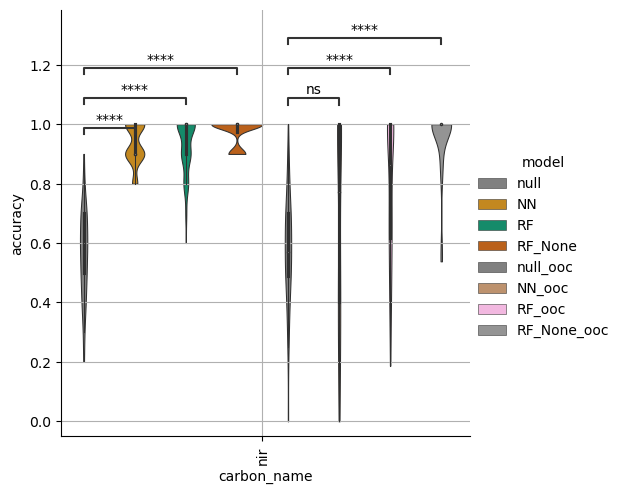

In [33]:
fig, stats=plot_fancy_model_comparison(results_all, hue_order=hue_order,stats=stats, model_pairs=model_pairs, multi_testing_correction=True)
fig

### Feature importance of actual DN genes? 

In [100]:
results_all=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/denitrification/zeqian_dn_results_all.pk")
colors=sns.color_palette('colorblind', DN_GENES['group'].nunique())
colors={i+1:c for i,c in enumerate(colors)}
colors[0]='grey'
_kos=[ko for ko in DN_GENES['ko'] if ko in zeqian_dn['ko_data'].columns]

highlight={}
for group, group_df in DN_GENES.groupby('group'):
    highlight[group]=group_df['ko'].tolist()

fi=cal_feature_importance(results_all[results_all['model']=='RF_None_ooc'], zeqian_dn['ko_data'],highlight=highlight,trim=100)



/home/zeqianli/ipykernel_3109059/730004950.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


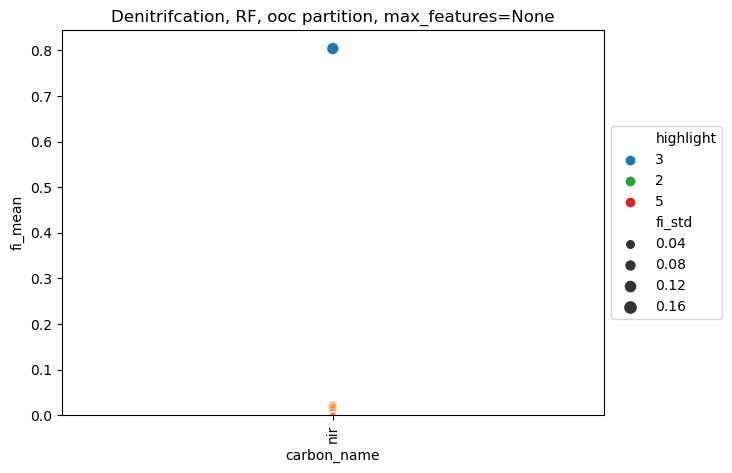

In [108]:
fig=plt.figure()
sns.scatterplot(data=fi, x='carbon_name',y='fi_mean',hue='highlight',size='fi_std') # ,palette=colors

# legend out, x lable 90
ax=plt.gca()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylim(bottom=0)

plt.title("Denitrifcation, RF, ooc partition, max_features=None")
plt.gcf()

# Archive

## RF hyperparameters

In [ ]:
for dataset_name, dataset in datasets.items():
    for model_name, (Model, model_params) in models.items():
        for split_name,split_param in split_params.items():
            try:
                print(f"Running {split_name} {model_name} {dataset_name}")
                ff_cache=f"{DIR_figure}/cache/{split_name}_{model_name}_{dataset_name}.pk"
                ff_results=f"{DIR_figure}/{split_name}_{model_name}_{dataset_name}.pk"
                
                if os.path.exists(ff_results):
                    print("Already done. Skipping. ")
                    continue
                ko_data,growth_data, tree,carbons=dataset['ko_data'],dataset['growth_data'],dataset['tree'],dataset['carbons']

                pipe=PredictionPipeline(Model,model_params=model_params, tree=tree, carbons=carbons, p=p,  ff_results=ff_cache, **split_param)
                pipe.generate_splits(ko_data,growth_data)
                results=pipe.run()
                with open(ff_results, 'wb') as f:
                    pickle.dump(results, f)
                print(f"Finished {split_name} {model_name} {dataset_name}")

            except Exception as e: 
                print(e)
                print(f"Failed to run {split_name} {model_name} {dataset_name}")
                

Running random null zeqian
Already done. Skipping. 
Running ooc null zeqian
Already done. Skipping. 
Running random RF_None_sqrt zeqian
Already done. Skipping. 
Running ooc RF_None_sqrt zeqian
Already done. Skipping. 
Running random RF_5_sqrt zeqian
Already done. Skipping. 
Running ooc RF_5_sqrt zeqian
Already done. Skipping. 
Running random RF_1_sqrt zeqian
Already done. Skipping. 
Running ooc RF_1_sqrt zeqian
Already done. Skipping. 
Running random RF_None_None zeqian


Training models...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 26.66it/s]


Finished random RF_None_None zeqian
Running ooc RF_None_None zeqian


Training models...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.13it/s]


Finished ooc RF_None_None zeqian
Running random RF_5_None zeqian


Training models...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.19it/s]


Finished random RF_5_None zeqian
Running ooc RF_5_None zeqian


Training models...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.17it/s]


Finished ooc RF_5_None zeqian
Running random RF_1_None zeqian


Training models...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 41.43it/s]


Finished random RF_1_None zeqian
Running ooc RF_1_None zeqian


Training models...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.82it/s]


Finished ooc RF_1_None zeqian
Running random null matti
Already done. Skipping. 
Running ooc null matti
Already done. Skipping. 
Running random RF_None_sqrt matti
Already done. Skipping. 
Running ooc RF_None_sqrt matti
Already done. Skipping. 
Running random RF_5_sqrt matti
Already done. Skipping. 
Running ooc RF_5_sqrt matti
Already done. Skipping. 
Running random RF_1_sqrt matti
Already done. Skipping. 
Running ooc RF_1_sqrt matti
Already done. Skipping. 
Running random RF_None_None matti


Training models...:  51%|██████████████████████████████████████████████████████▉                                                     | 6006/11800 [07:19<03:40, 26.25it/s]

In [ ]:
dataset_name='zeqian'
results_all=[]
for model_name, (Model, model_params) in models.items():
    for split_name,split_param in split_params.items():
        try:
            results=pd.read_pickle(f"{DIR_figure}/{split_name}_{model_name}_{dataset_name}.pk")
            results['model']=model_name
            results['split']=split_name
            results['dataset_name']=dataset_name
            results_all.append(results)
        except FileNotFoundError:
            print(f"File not found for {split_name}_{model_name}_{dataset_name}")

results_all=pd.concat(results_all,axis=0,ignore_index=True)
results_all.to_pickle(f"{DIR_data}/figure_data/3A/zeqian_results_all.pk")

## Denitrification

In [ ]:
pipe=PredictionPipeline(RF, model_params={}, carbons=['nir'],split_method='random',splitter_params={'test_set_ratio':0.2},n_splits=100,tree=tree)
pipe.generate_splits(kos_data, dn)
results_rf_random=pipe.run()

pipe=PredictionPipeline(BernoulliNull, model_params={}, carbons=['nir'],split_method='random',splitter_params={'test_set_ratio':0.2},n_splits=100,tree=tree)
pipe.generate_splits(kos_data, dn)
results_bernoulli_random=pipe.run()

pipe=PredictionPipeline(RF, model_params={}, carbons=['nir'],split_method='ooc',splitter_params={'test_set_range':(0.1,0.25), 'min_zeros':0,'min_ones':0},n_splits=100,tree=tree)
pipe.generate_splits(kos_data, dn)
results_rf_ooc=pipe.run()

pipe=PredictionPipeline(BernoulliNull, model_params={}, carbons=['nir'],split_method='ooc',splitter_params={'test_set_range':(0.1,0.25), 'min_zeros':0,'min_ones':0},n_splits=100,tree=tree)
pipe.generate_splits(kos_data, dn)
results_bernoulli_ooc=pipe.run()

Training models...: 100%|██████████| 100/100 [00:00<00:00, 254.77it/s]


(<Figure size 1500x1000 with 2 Axes>,
 [array([<AxesSubplot: title={'center': 'nir'}, xlabel='model_label', ylabel='accuracy'>,
         <AxesSubplot: xlabel='model_pair', ylabel='pvalue'>], dtype=object)])

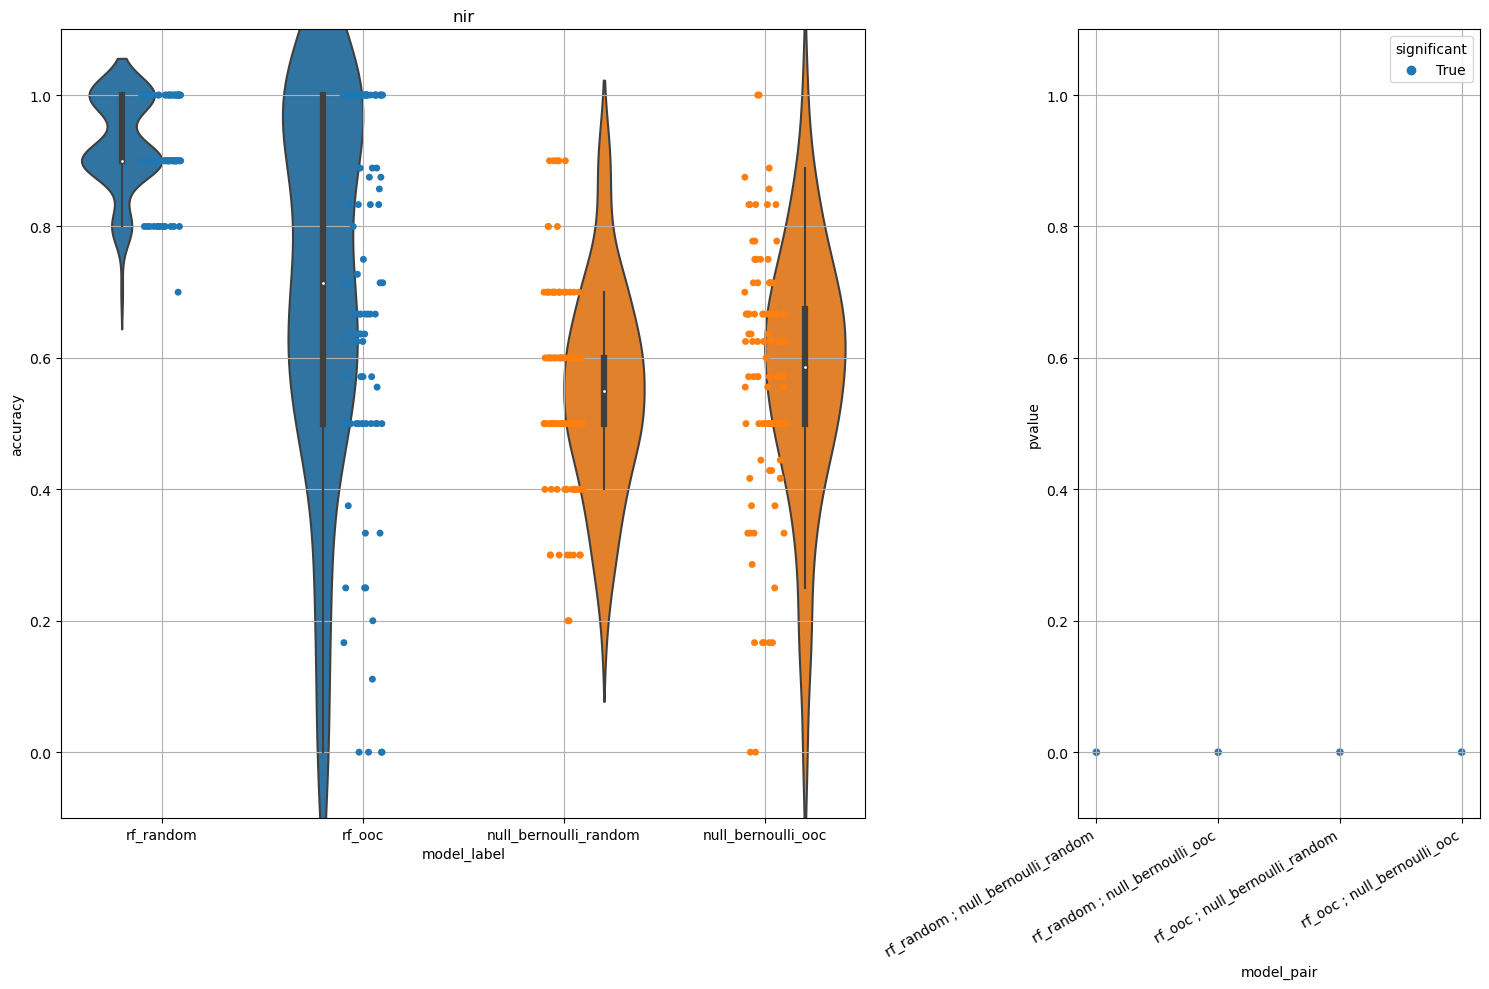

In [ ]:
plot_model_comparison({'rf_random':results_rf_random,'null_bernoulli_random':results_bernoulli_random,'rf_ooc':results_rf_ooc,'null_bernoulli_ooc':results_bernoulli_ooc},carbons=['nir'],p_pairs=None,figsize=(15,10))

## Why RF fails

In [ ]:
results_all=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/figure_data/SI/fba_gapfilling/panel_1/results_all.pk")

model_pairs=[(m, 'null') for m in ['fba','fba_gapfill','fba_force_uptake','fba_force_uptake_gapfill']]
hue_order=['null', 'fba', 'fba_gapfill', 'fba_force_uptake', 'fba_force_uptake_gapfill']
stats=compare_models(results_all, 
                    model_pairs=[
                        (*model_pair, one_sample_test) for model_pair in model_pairs
                    ],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy',
                    p_threshold=0.05,
                    multi_testing_correction=False).set_index('carbon_name')

100%|██████████| 10/10 [00:00<00:00, 126.33it/s]


In [ ]:
from sklearn.metrics import pairwise_distances

results=[]
splitters={'random':[RandomSplitter, {'test_set_ratio':0.2}],
            'ooc': [LargeTreeTraverseOOCSplitter, {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None, 'tree': zeqian['tree']}]}
n_split=20

for c in tqdm(zeqian['carbons']):
    samples_mask=zeqian['growth_data'][zeqian['growth_data'][c].notna()].index.values
    X=zeqian['ko_data'].loc[samples_mask]
    y=zeqian['growth_data'][c].loc[samples_mask]

    for split_name, (Splitter, splitter_params) in splitters.items():
        if split_name=='ooc':
            splitter_params=splitter_params.copy()
            splitter_params['growth_data']=y
        splitter=Splitter(**splitter_params)
        splits=splitter.generate_splits(samples_mask,n=n_split)
        for i,test_samples in enumerate(splits):
            train_samples=np.setdiff1d(samples_mask, test_samples)
            rf=RandomForestClassifier(n_estimators=100,max_features=None)
            X_shuffled=X.loc[train_samples,:].copy() # ,np.random.permutation(X.columns)
            X_shuffled.columns=X.columns
            y_shuffled=y.loc[train_samples].copy()
            rf.fit(X_shuffled,y_shuffled)

            neighbor_samples=[]
            neighbor_distances=[]
            for test_sample in test_samples:
                neighbor, neighbor_dist=None,None
                for s in train_samples:
                    dist=np.abs(X.loc[s,:].values-X.loc[test_sample,:].values).sum()
                    if neighbor is None or dist<neighbor_dist:
                        neighbor, neighbor_dist=s, dist
                neighbor_samples.append(neighbor)
                neighbor_distances.append(neighbor_dist)
            
        test_pred, neighbor_pred=rf.predict(X.loc[test_samples,:]), rf.predict(X.loc[neighbor_samples,:])
        # for t, t_sample, n,n_sample,n_distance in zip(test_pred, test_samples, neighbor_pred, neighbor_samples,neighbor_distances):
            # results.append({'carbon_name':c, 'split':split_name, 'i_split':i, 'test_sample':t_sample, 'test_pred':t, 'neighbor_sample': n_sample, 'neighbor_pred':n,'neighbor_distance':n_distance})
        results.append({'carbon_name':c, 'split':split_name,  'test_samples':test_samples, 'test_pred':test_pred, 'neighbor_sample': neighbor_samples, 'neighbor_pred':neighbor_pred, 'mean_diff': np.mean(np.abs(neighbor_pred-test_pred)),'neighbor_distance_mean':np.mean(neighbor_distances)})
    

100%|██████████| 10/10 [05:25<00:00, 32.53s/it]


In [ ]:
results=pd.DataFrame(results)
results['diff']=(results['test_pred']-results['neighbor_pred']).abs()


In [ ]:
sns.catplot(data=results, x='carbon_name', y='mean_diff',cut=0,kind='violin',col='split')

In [ ]:
plt.gcf()

## MI

In [ ]:
import sklearn.metrics as metrics 
from scipy.stats import entropy

def mutual_info(arr1, arr2, signed=False):
    #return metrics.adjusted_mutual_info_score(arr1, arr2)
    mi=metrics.mutual_info_score(arr1, arr2)
    if signed:
        mi=mi*np.sign(np.corrcoef(arr1, arr2)[0,1])
    return mi

def neg_conditional_entropy(arr1, arr2):
    p=arr1.mean()
    
    def _entropy(arr):
        if np.all(arr==0) or np.all(arr==1):
            return 0
        else:
            return entropy(arr)
    
    if p==0 or p==1:
        return -_entropy(arr2)
    else:
        return -p*_entropy(arr2[arr1==1])-(1-p)*_entropy(arr2[arr1==0])

def _pickleable_cal_mi(key, past_explainer, new_explainer, y,metric,past_logic):
    # TODO: The logic sequence method won't work. E.g. [001,010,100], [1,2,3]. 
    # Change this to allow multiple arrays as the past explainer. 
    logics=['&','|','!&','!|']

    if metric=='mutual_info':
        f=mutual_info
    elif metric=='neg_conditional_entropy':
        f=neg_conditional_entropy
    else:
        raise ValueError(f"metric {metric} not recognized")

    if past_explainer is None:
        explainer=new_explainer
        mi=f(new_explainer,y)
        logic=[]
    else:
        _explainers=[np.logical_and(past_explainer, new_explainer).astype(int),
                             np.logical_or(past_explainer, new_explainer).astype(int),
                             np.logical_and(np.logical_not(past_explainer),new_explainer).astype(int), 
                             np.logical_or(np.logical_not(past_explainer),new_explainer).astype(int)
                             ]
        _mis=[f(_explainer,y) for _explainer in _explainers]
        _ind=np.argmax(_mis)
        mi=_mis[_ind]
        explainer=_explainers[_ind]
        logic=[*past_logic,logics[_ind]]
    
    return key, mi, explainer,logic

def get_top_features(X, y, keep_top=1,
            max_features=5, metric='mutual_info', verbose=False, trim=500,
            p=None):

    if keep_top!=1 and isinstance(keep_top, float):
        keep_top=int(keep_top*X.shape[1])
    features=X.columns
    if isinstance(y,pd.Series):
        y=y.values
    past_best=None
    df=[]
    
    _iter=range(1, max_features+1)
    if verbose:
        _iter=tqdm(_iter, desc="Number of features")
    for i in _iter:
        _batch=[]
        # _best=None
        for feature in features:
            if past_best is None:
                _batch.append((feature, None, X[feature].values, y,metric,None))
            else:
                for _past_features, _past_explainer,_past_logic in past_best:
                    if not feature in _past_features:
                        _batch.append((_past_features+','+feature, _past_explainer, X[feature].values, y, metric,_past_logic))
        if p is None:
            _res=[_pickleable_cal_mi(*args) for args in _batch]
        else:
            _res=p.starmap(_pickleable_cal_mi, _batch)
        
        _res=pd.DataFrame(_res, columns=["features", "mi", "explainer",'logic']).sort_values("mi", ascending=False)
        if trim:
            _res=_res.iloc[:trim, :]
        past_best=_res.iloc[:keep_top, :][['features','explainer','logic']].values

        df.append(_res)
    df=pd.concat(df,axis=0,ignore_index=True)
    df['n_features']=df['features'].apply(lambda x: len(x.split(',')))
    df=df.sort_values(['n_features','mi'], ascending=[True,False])
    return df


In [ ]:
# Zeqian data 

metric='mutual_info'
ko_data, growth_data,carbons=zeqian['ko_data'],zeqian['growth_data'],zeqian['carbons']

df_all=[]
for c in tqdm(carbons, desc="Carbon"):
    y=growth_data[c]
    _ind=y[y.notna()].index
    y=y.loc[_ind]
    X=ko_data.loc[_ind]

    df=get_top_features(X, y, max_features=5,keep_top=5,p=p,trim=500, metric=metric,verbose=False)
    df['carbon_name']=c
    df_all.append(df)

df_all=pd.concat(df_all,axis=0,ignore_index=True)
df_all.to_pickle(f"{DIR_figure}/zeqian_{metric}.pk")

Carbon: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [08:16<00:00, 49.66s/it]


Text(0.5, 0.98, 'mutual_info')

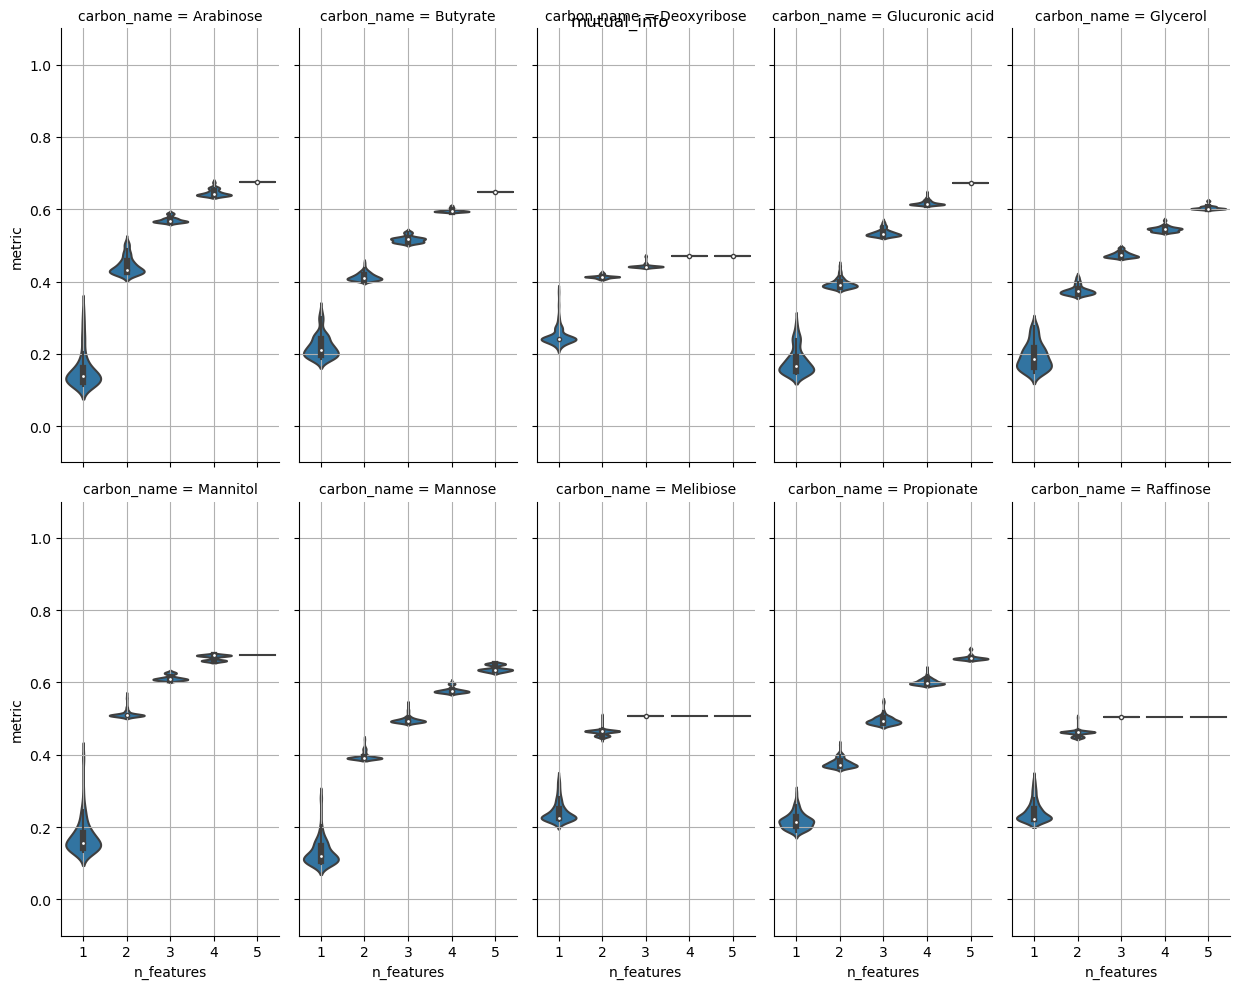

In [ ]:
# Plot
metric='mutual_info'

df_all=pd.read_pickle(f"{DIR_figure}/zeqian_{metric}.pk")
df_all=df_all.sort_values(by=['carbon_name','n_features','metric'], ascending=[True,True,False])
df_all['_dummy']=1
df_top=df_all.groupby(['carbon_name','n_features']).head(100)
sns.catplot(data=df_top, x="n_features", y="metric", col="carbon_name", hue='_dummy',aspect=.5,kind='violin',col_wrap=5,legend=False)

for ax in plt.gcf().axes:
    ax.set_ylim(-0.1,1.1)
    ax.grid()
    
fig=plt.gcf()
fig.suptitle(metric)


### NCE training vs test

In [ ]:
p=Pool(48)

In [ ]:
def _entropy(arr):
    if np.all(arr==0) or np.all(arr==1):
        return 0
    else:
        return entropy(arr)

def neg_conditional_entropy(arr1, arr2):
    if isinstance(arr1,list):
        arr1=np.array(arr1)
    if arr1.ndim!=1:
        arr1=(arr1 * np.array([[2**j for j in range(arr1.shape[1])] for i in range(arr1.shape[0])])).sum(axis=1) # binary coding
    vs, counts = np.unique(arr1, return_counts=True)
    ce=0

    for v, count in zip(vs, counts):
        ce+=-count/len(arr1)*_entropy(arr2[arr1==v])    
    return ce

def _pickleable_cal_nce(key, explainer, y):
    nce=neg_conditional_entropy(explainer, y)
    return key, nce

class NCEFeatureSelection(BinaryGrowthClassifier):

    def __init__(self,
                 Model, model_params, 
                 keep_top=5, max_features=5, n_feature_subsample=None, 
                 threads=1, p=None, 
                 # ff_results=None,
                 # multithreading_batch=None, 
                 save_feature_selection_data=True,
                 verbose=False):
        self.Model = Model
        self.model_params = model_params
        self.max_features = max_features
        self.n_feature_subsample = n_feature_subsample

        self.threads = threads 
        if multithreading_batch is None:
            multithreading_batch = threads * 5
        self.multithreading_batch = multithreading_batch

        if threads>1 and p is None:
            raise ValueError("A Pool object is required for multithreading.")
        self._p = p  # multiprocessing pool
        self.save_feature_selection_data  = save_feature_selection_data
        self._feature_selection_data = []

        self.verbose=verbose

        # Caching
        # if ff_results is not None and os.path.exists(ff_results):
        #     print(f"Warning: output file {ff_results} exists. ")
        #     i = 0
        #     _spl = ff_results.split('.')
        #     while os.path.exists(ff_results):
        #         ff_results = '.'.join(_spl[:-1])+'_'+str(i)+'.'+_spl[-1]
        #         i += 1
        #     print(f"Changed to {ff_results}. ")
        # self.ff_results = ff_results
        # self._results = []

        self._best_features, self._best_accuracies = None, None
        self.final_features, self.final_features_nce, self.final_model = None, None, None

    def fit(self,X,y):
        df=self.get_top_features(X, y) # feature selection data 
        if self.save_feature_selection_data:
            self._feature_selection_data = df
        self.final_features=df[df['n_features']==self.max_features].sort_values('nce')['features'].values[0]
        self.final_features_nce=np.array([df[df['features_str']==(','.join(self.final_features[:(_+1)]))]['nce'].values[0] for _ in range(self.max_features)])

        # train final model
        self.final_model=self.Model(**self.model_params)
        self.final_model.fit(X[self.final_features], y)

    def predict(self, X):
        return self.final_model.predict(X[self.final_features])

    def get_params(self, deep=True):
        return {'final_features': self.final_features, 'final_features_nce': self.final_features_nce}

    def get_top_features(self,X, y):
        if self.keep_top!=1 and isinstance(self.keep_top, float):
            self.keep_top=int(self.keep_top*X.shape[1])
        features=X.columns
        if isinstance(y,pd.Series):
            y=y.values
        past_best=None
        df=[]
        
        _iter=range(1, self.max_features+1)
        if self.verbose:
            _iter=tqdm(_iter, desc="Number of features")
        for i in _iter:
            _batch=[]
            if self.n_feature_subsample is None:
                features=X.columns
            else:
                features=np.random.choice(X.columns, self.n_feature_subsample, replace=False)
            for feature in features:
                if past_best is None:
                    _batch.append(([feature], X[feature].values, y))
                else:
                    for past_features in past_best:
                        if not feature in past_features:
                            new_features=[*past_features, feature]
                            _batch.append((new_features,X[new_features].values, y))
            if self._p is None:
                _res=[_pickleable_cal_nce(*args) for args in _batch]
            else:
                _res=self._p.starmap(_pickleable_cal_nce, _batch)
            
            _res=pd.DataFrame(_res, columns=["features", "nce"]).sort_values("nce", ascending=False)
            if isinstance(self.save_feature_selection_data, int):
                _res=_res.iloc[:self.save_feature_selection_data, :]
            past_best=_res.iloc[:self.keep_top, :]['features'].values
            df.append(_res)
        df=pd.concat(df,axis=0,ignore_index=True)
        df['n_features']=df['features'].apply(lambda x: len(x))
        df['features_str']=df['features'].apply(lambda x: ','.join(x))
        df=df.sort_values(['n_features',"nce"], ascending=[True,False])
        return df

In [ ]:
n_splits=20
metrics=['neg_conditional_entropy']
ko_data, growth_data,carbons=zeqian['ko_data'],zeqian['growth_data'],zeqian['carbons']

splitters={'random':[RandomSplitter,{'test_set_ratio':0.2}],
           'ooc':   [LargeTreeTraverseOOCSplitter,{'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None,'tree': zeqian['tree']}]
           }
        
df_all=[]

for c in carbons:
    y=growth_data[c]
    samples_mask=y[y.notna()].index
    y=y.loc[samples_mask]
    X=ko_data.loc[samples_mask]
    # for c in tqdm(carbons, desc="Carbon"):
    for split_name, (Splitter,splitter_kwargs) in splitters.items():
        if split_name=='ooc':
            splitter_kwargs.update({'growth_data':y})
        splitter=Splitter(**splitter_kwargs)
       
        for i_split,test_samples in tqdm(enumerate(splitter.generate_splits(samples_mask, n_splits)),desc=f'{c}, {split_name}'):
            for metric in metrics:
                train_samples=np.setdiff1d(samples_mask,test_samples)
                X_train, y_train=X.loc[train_samples,:], y.loc[train_samples]
                df=get_top_features(X, y, max_features=5,keep_top=5,p=p,trim=500, metric=metric,verbose=False)
                df.rename(columns={'metric':'train_metric'})
                df['carbon_name']=c
                df['split']=split_name
                df['method']=metric
                df['i_split']=i_split
                df['test_samples']=[test_samples]*df.shape[0]
                df['train_samples']=[train_samples]*df.shape[0]
                df_all.append(df)

df_all=pd.concat(df_all,axis=0,ignore_index=True)
df_all.to_pickle(f"{DIR_figure}/zeqian_split_{metric}.pk")

Arabinose, random: 20it [15:43, 47.20s/it]
Arabinose, ooc: 20it [16:02, 48.12s/it]
Butyrate, random: 20it [15:49, 47.49s/it]
Butyrate, ooc: 20it [15:52, 47.62s/it]
Deoxyribose, random: 20it [15:32, 46.65s/it]
Deoxyribose, ooc: 20it [15:14, 45.74s/it]
Glucuronic acid, random: 20it [15:31, 46.57s/it]
Glucuronic acid, ooc: 20it [15:28, 46.41s/it]
Glycerol, random: 20it [15:29, 46.49s/it]
Glycerol, ooc: 20it [15:29, 46.47s/it]
Mannitol, random: 20it [15:29, 46.49s/it]
Mannitol, ooc: 20it [15:38, 46.92s/it]
Mannose, random: 20it [15:31, 46.60s/it]
Mannose, ooc: 20it [15:39, 46.95s/it]
Melibiose, random: 20it [15:34, 46.72s/it]
Melibiose, ooc: 20it [15:32, 46.64s/it]
Propionate, random: 20it [15:34, 46.73s/it]
Propionate, ooc: 20it [15:40, 47.02s/it]
Raffinose, random: 20it [15:30, 46.51s/it]
Raffinose, ooc: 20it [15:43, 47.17s/it]


In [ ]:
# Function definition must proceeds creating the Pool
def cal_ce_row(row):
    arr1=zeqian['ko_data'].loc[row['test_samples'], row['features']].values
    arr2=zeqian['growth_data'].loc[row['test_samples'],row['carbon_name']].values
    return neg_conditional_entropy(arr1, arr2) # TODO: change this to training a decision tree on the features, and calculate the model prediction accuracy on the test set. 

metric='neg_conditional_entropy'

df_all=pd.read_pickle(f"{DIR_figure}/zeqian_split_{metric}.pk")
df_all=df_all.rename(columns={'metric':'train_metric'})

ce=p.map(cal_ce_row, [row for _, row in df_all.iterrows()])

df_all['test_metric']=ce
df_all.to_pickle(f"{DIR_figure}/zeqian_split_{metric}.pk")

#### Train RF on top features in the training set, and do prediction on the test set

In [ ]:
df_all=pd.read_pickle(f"{DIR_figure}/zeqian_split_neg_conditional_entropy.pk")

In [ ]:
df_all

,features,train_metric,n_features,carbon_name,split,method,i_split,test_samples,train_samples,metric_test
0,[K10820],-2.415669,1,Arabinose,random,neg_conditional_entropy,0,"[sif0715, sid0605, sia0902, sie1917, OTU4908, ...","[HMWF001, HMWF003, HMWF005, HMWF008, HMWF009, ...",-0.793442
1,[K23509],-2.415669,1,Arabinose,random,neg_conditional_entropy,0,"[sif0715, sid0605, sia0902, sie1917, OTU4908, ...","[HMWF001, HMWF003, HMWF005, HMWF008, HMWF009, ...",-0.793442
2,[K23508],-2.415669,1,Arabinose,random,neg_conditional_entropy,0,"[sif0715, sid0605, sia0902, sie1917, OTU4908, ...","[HMWF001, HMWF003, HMWF005, HMWF008, HMWF009, ...",-0.793442
3,[K10439],-2.774945,1,Arabinose,random,neg_conditional_entropy,0,"[sif0715, sid0605, sia0902, sie1917, OTU4908, ...","[HMWF001, HMWF003, HMWF005, HMWF008, HMWF009, ...",-1.039721
4,[K13641],-2.782446,1,Arabinose,random,neg_conditional_entropy,0,"[sif0715, sid0605, sia0902, sie1917, OTU4908, ...","[HMWF001, HMWF003, HMWF005, HMWF008, HMWF009, ...",-1.341198
...,...,...,...,...,...,...,...,...,...,...
999995,"[K25182, K02455, K01989, K12282, K12147]",0.000000,5,Raffinose,ooc,neg_conditional_entropy,19,"[HMWF010, HMWF016, HMWF017, OTU5201, sia0102, ...","[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...",0.000000
999996,"[K25182, K02455, K08351, K12282, K12151]",0.000000,5,Raffinose,ooc,neg_conditional_entropy,19,"[HMWF010, HMWF016, HMWF017, OTU5201, sia0102, ...","[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...",0.000000
999997,"[K25182, K02455, K00001, K12283, K12204]",0.000000,5,Raffinose,ooc,neg_conditional_entropy,19,"[HMWF010, HMWF016, HMWF017, OTU5201, sia0102, ...","[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...",0.000000
999998,"[K25182, K02455, K08350, K12283, K12204]",0.000000,5,Raffinose,ooc,neg_conditional_entropy,19,"[HMWF010, HMWF016, HMWF017, OTU5201, sia0102, ...","[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...",0.000000


In [ ]:
df_all['features_str']=df_all['features'].map(lambda x: ','.join(np.sort(x)))
min_metric_value=df_all['train_metric'].min()
n_split=df_all['i_split'].max()+1

def mean_metric(group):
    return (group['train_metric'].sum()+min_metric_value*(n_split-group.shape[0]))/n_split

df_mean=df_all.groupby(['carbon_name','split','n_features','features_str']).apply(mean_metric).reset_index().rename(columns={0:'train_mean'})

N_top=100
df_mean=df_mean.sort_values(by=['carbon_name','split','n_features','train_mean'], ascending=[True,True,True,False])

df_mean=df_mean.groupby(['carbon_name','split','n_features']).head(N_top)

df_mean.merge(df_all, on=['carbon_name','split','n_features','features_str'], how='left')

In [ ]:

rf_params={'n_estimators':100,'max_features':None}

def train_test_RF(row):
    X_train=zeqian['ko_data'].loc[row['train_samples'], row['features']].values
    y_train=zeqian['growth_data'].loc[row['train_samples'],row['carbon_name']].values
    X_test=zeqian['ko_data'].loc[row['test_samples'], row['features']].values
    y_test=zeqian['growth_data'].loc[row['test_samples'],row['carbon_name']].values
    out=row.to_dict()
    rf=RF(**rf_params)
    rf.fit(X_train,y_train)
    out.update(rf.score(X_test,y_test))
    return out


In [ ]:
p=Pool(48)

In [ ]:

batch_size=48*10
_batch=[]
split_rf_nce=[]
for _, row in tqdm(df_all.iterrows(), total=df_all.shape[0]):
    _batch.append(row)
    if len(_batch)>=batch_size:
        split_rf_nce.extend(p.map(train_test_RF, _batch))
        _batch=[]

df=pd.DataFrame(split_rf_nce)
df.to_pickle(f"{DIR_figure}/zeqian_split_nce_rf.pk")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [40:11<00:00, 414.71it/s]


In [ ]:
# Plot

df_all=pd.read_pickle(f"{DIR_figure}/zeqian_split_nce_rf.pk")

In [ ]:
df_all['features_str']=df_all['features'].map(lambda x: ','.join(np.sort(x)))
min_metric_value=df_all['train_metric'].min()
n_split=df_all['i_split'].max()+1

def mean_metric(group):
    return {'train_metric_mean': (group['train_metric'].sum()+min_metric_value*max((n_split-group.shape[0]),0))/max(group.shape[0],n_split),
            'test_accuracy_mean': group['accuracy'].mean()}

df_mean=[]
for (carbon_name, split, n_featurs, features_str),group in df_all.groupby(['carbon_name','split','n_features','features_str']):
    out={'carbon_name':carbon_name,'split':split,'n_features':n_featurs,'features_str':features_str}
    out.update(mean_metric(group))
    df_mean.append(out)

df_mean=pd.DataFrame(df_mean)
# N_top=100
df_mean=df_mean.sort_values(by=['carbon_name','split','n_features','train_metric_mean'], ascending=[True,True,True,False])

# df_mean=df_mean.groupby(['carbon_name','split','n_features']).head(N_top)

# df_mean.merge(df_all, on=['carbon_name','split','n_features','features_str'], how='left')

In [ ]:
df_mean=df_mean.sort_values(by=['carbon_name','split','n_features','train_metric_mean'], ascending=[True,True,True,False])


In [ ]:
df_all[(df_all['carbon_name']=='Raffinose') & (df_all['n_features']==2) & (df_all['split']=='ooc') & (df_all['i_split']==4)]

,features,train_metric,n_features,carbon_name,split,method,i_split,test_samples,train_samples,metric_test,true_negative,false_positive,false_negative,true_positive,accuracy,precision,sensitivity,specificity,f1_score,balanced_accuracy,features_str
960500,"[K25182, K02455]",0.000000,2,Raffinose,ooc,neg_conditional_entropy,4,"[OTU672, OTU736, sid0104, sid0204, sid0306, si...","[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...",0.0,3,0,0,8,1.0,1.0,1.0,1.0,1.0,1.0,"K02455,K25182"
960501,"[K19802, K16090]",-0.073739,2,Raffinose,ooc,neg_conditional_entropy,4,"[OTU672, OTU736, sid0104, sid0204, sid0306, si...","[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...",0.0,3,0,0,8,1.0,1.0,1.0,1.0,1.0,1.0,"K16090,K19802"
960502,"[K19802, K07336]",-0.073739,2,Raffinose,ooc,neg_conditional_entropy,4,"[OTU672, OTU736, sid0104, sid0204, sid0306, si...","[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...",0.0,3,0,0,8,1.0,1.0,1.0,1.0,1.0,1.0,"K07336,K19802"
960503,"[K19802, K25180]",-0.073739,2,Raffinose,ooc,neg_conditional_entropy,4,"[OTU672, OTU736, sid0104, sid0204, sid0306, si...","[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...",0.0,3,0,0,8,1.0,1.0,1.0,1.0,1.0,1.0,"K19802,K25180"
960504,"[K25182, K02671]",-0.081113,2,Raffinose,ooc,neg_conditional_entropy,4,"[OTU672, OTU736, sid0104, sid0204, sid0306, si...","[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...",0.0,3,0,0,8,1.0,1.0,1.0,1.0,1.0,1.0,"K02671,K25182"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960995,"[K25182, K22086]",-0.331219,2,Raffinose,ooc,neg_conditional_entropy,4,"[OTU672, OTU736, sid0104, sid0204, sid0306, si...","[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...",0.0,3,0,0,8,1.0,1.0,1.0,1.0,1.0,1.0,"K22086,K25182"
960996,"[K25182, K09826]",-0.331219,2,Raffinose,ooc,neg_conditional_entropy,4,"[OTU672, OTU736, sid0104, sid0204, sid0306, si...","[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...",0.0,3,0,0,8,1.0,1.0,1.0,1.0,1.0,1.0,"K09826,K25182"
960997,"[K25182, K01560]",-0.331219,2,Raffinose,ooc,neg_conditional_entropy,4,"[OTU672, OTU736, sid0104, sid0204, sid0306, si...","[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...",0.0,3,0,0,8,1.0,1.0,1.0,1.0,1.0,1.0,"K01560,K25182"
960998,"[K25182, K22085]",-0.331219,2,Raffinose,ooc,neg_conditional_entropy,4,"[OTU672, OTU736, sid0104, sid0204, sid0306, si...","[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...",0.0,3,0,0,8,1.0,1.0,1.0,1.0,1.0,1.0,"K22085,K25182"


### Features selection result

In [ ]:
df_top=df_all.sort_values('train_metric',ascending=False).groupby(['carbon_name','i_split','n_features','split']).head(1).reset_index()

In [ ]:
df_top

,index,features,train_metric,n_features,carbon_name,split,method,i_split,test_samples,train_samples,metric_test,true_negative,false_positive,false_negative,true_positive,accuracy,precision,sensitivity,specificity,f1_score,balanced_accuracy,features_str
0,999839,"[K25182, K02455, K08350, K12283, K12057]",0.000000,5,Raffinose,ooc,neg_conditional_entropy,19,"[HMWF010, HMWF016, HMWF017, OTU5201, sia0102, ...","[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...",0.000000,13,0,0,0,1.000000,NaN,NaN,1.000000,NaN,NaN,"K02455,K08350,K12057,K12283,K25182"
1,218454,"[K00875, K02666]",0.000000,2,Deoxyribose,random,neg_conditional_entropy,7,"[sic0404, sif0514, HMWF028, sif2231, OTU2469, ...","[HMWF001, HMWF003, HMWF005, HMWF006, HMWF009, ...",0.000000,16,0,0,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,"K00875,K02666"
2,218672,"[K00875, K13932, K12518]",0.000000,3,Deoxyribose,random,neg_conditional_entropy,7,"[sic0404, sif0514, HMWF028, sif2231, OTU2469, ...","[HMWF001, HMWF003, HMWF005, HMWF006, HMWF009, ...",0.000000,16,0,0,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,"K00875,K12518,K13932"
3,219005,"[K00875, K06213, K12283, K12282]",0.000000,4,Deoxyribose,random,neg_conditional_entropy,7,"[sic0404, sif0514, HMWF028, sif2231, OTU2469, ...","[HMWF001, HMWF003, HMWF005, HMWF006, HMWF009, ...",0.000000,16,0,0,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,"K00875,K06213,K12282,K12283"
4,592099,"[K00769, K10227, K03503, K13796, K12276]",0.000000,5,Mannitol,ooc,neg_conditional_entropy,16,"[HMWF018, HMWF029, OTU2469, OTU3427, OTU736, s...","[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...",0.000000,10,2,0,11,0.913043,0.846154,1.000000,0.833333,0.916667,0.916667,"K00769,K03503,K10227,K12276,K13796"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,822500,[K09165],-2.497395,1,Propionate,random,neg_conditional_entropy,9,"[sif2232, sic1001, sib0509, sif0617, sid0505, ...","[HMWF003, HMWF005, HMWF006, HMWF009, HMWF010, ...",-1.467841,5,4,0,8,0.764706,0.666667,1.000000,0.555556,0.800000,0.777778,K09165
1996,812500,[K09165],-2.497395,1,Propionate,random,neg_conditional_entropy,5,"[sif0513, sif0532, OTU736, sif2231, OTU4908, O...","[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...",-1.467841,5,4,0,8,0.764706,0.666667,1.000000,0.555556,0.800000,0.777778,K09165
1997,887500,[K09165],-2.497395,1,Propionate,ooc,neg_conditional_entropy,15,"[HMWF018, HMWF029, OTU3427, OTU4895, OTU4908, ...","[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...",0.000000,10,0,1,2,0.923077,1.000000,0.666667,1.000000,0.800000,0.833333,K09165
1998,820000,[K09165],-2.497395,1,Propionate,random,neg_conditional_entropy,8,"[HMWF017, sif1233, sib0112, sib0402, OTU4895, ...","[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...",-0.915722,9,1,0,7,0.941176,0.875000,1.000000,0.900000,0.933333,0.950000,K09165


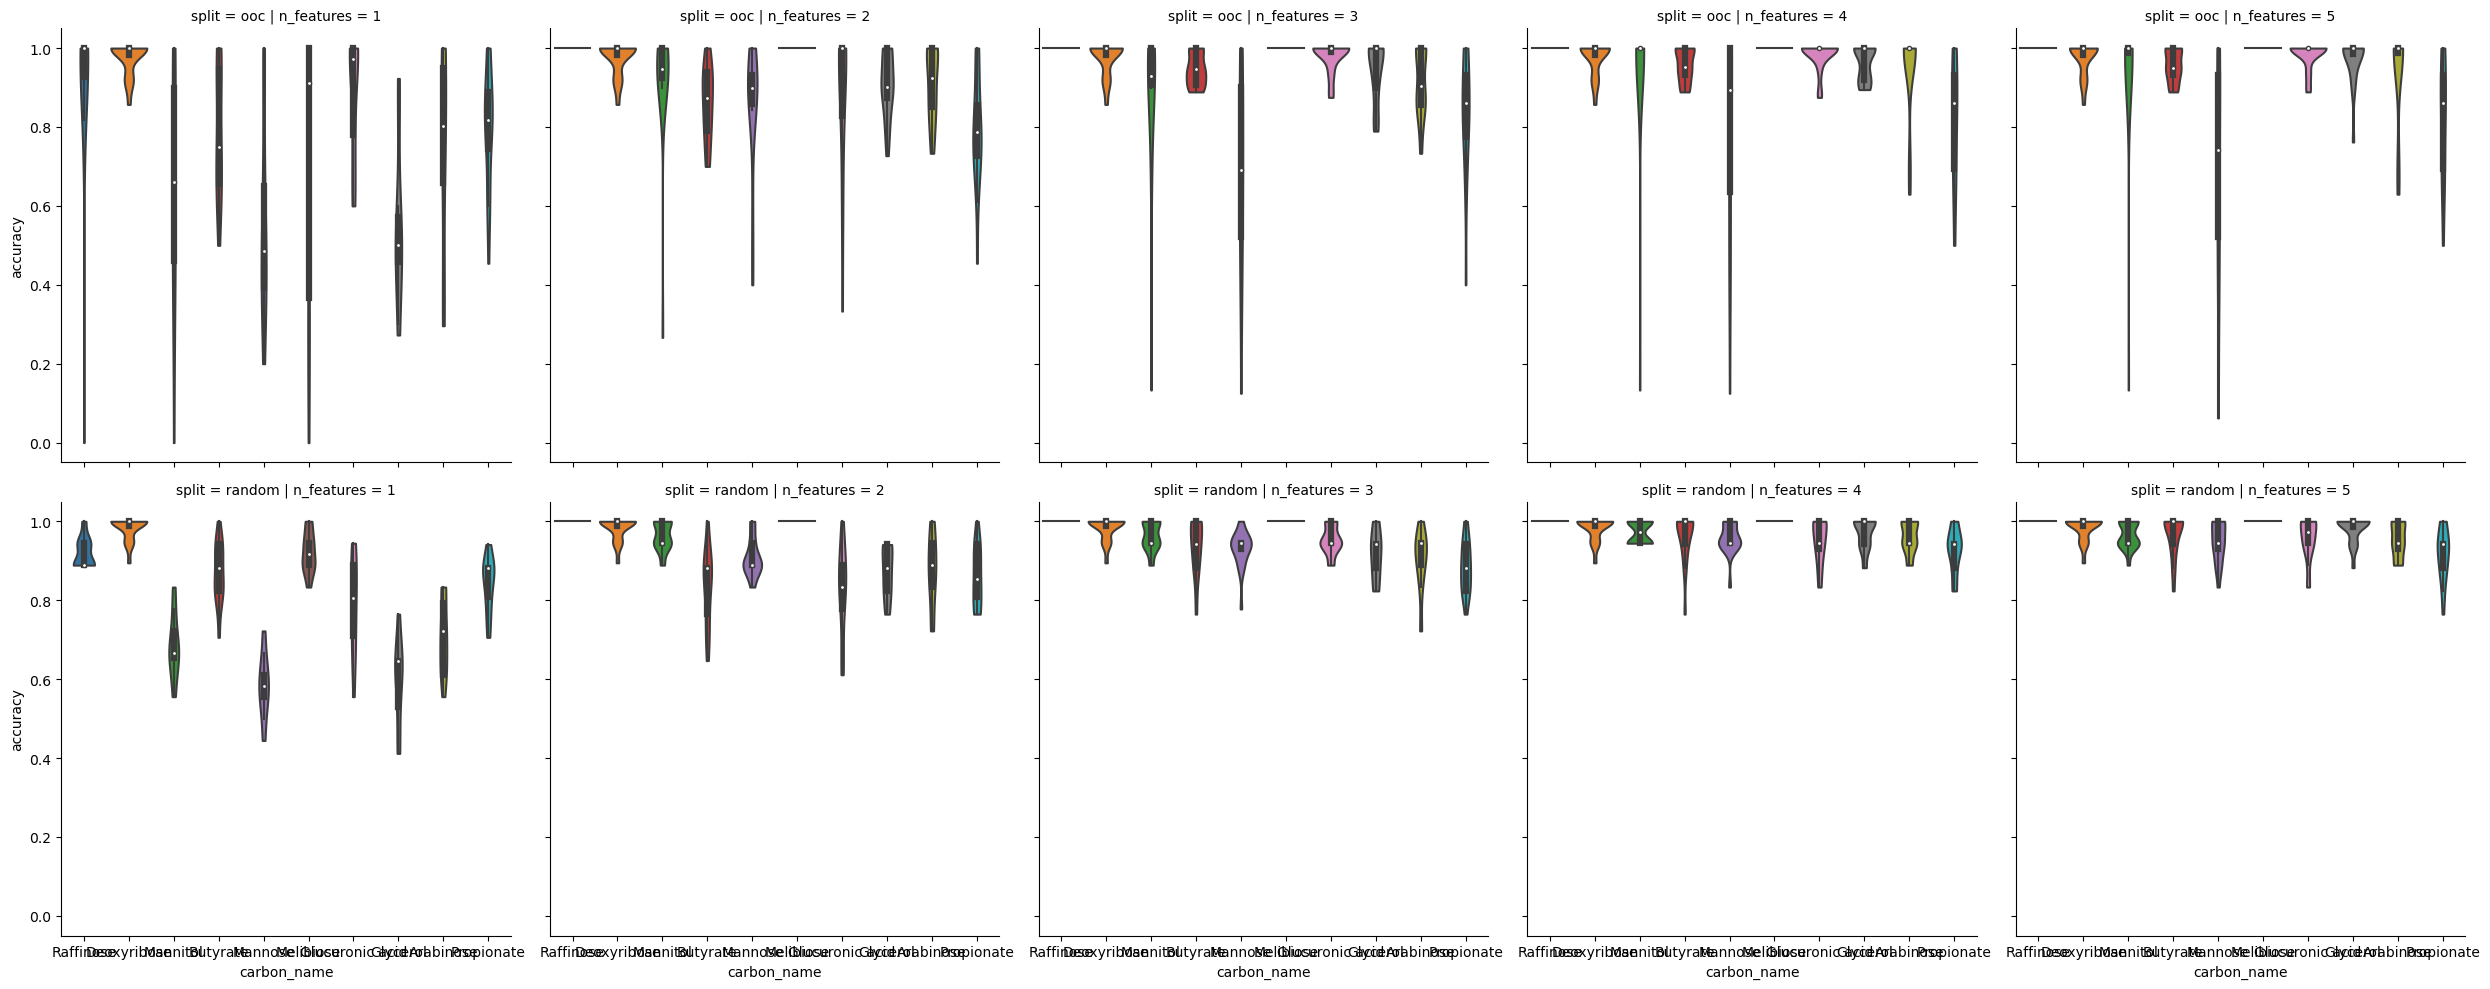

In [ ]:
sns.catplot(data=df_top, x='carbon_name', y='accuracy', row='split', col='n_features', kind='violin',cut=0)
plt.gcf()

In [ ]:
df_top

,index,features,train_metric,n_features,carbon_name,split,method,i_split,test_samples,train_samples,metric_test,true_negative,false_positive,false_negative,true_positive,accuracy,precision,sensitivity,specificity,f1_score,balanced_accuracy,features_str
0,999839,"[K25182, K02455, K08350, K12283, K12057]",0.000000,5,Raffinose,ooc,neg_conditional_entropy,19,"[HMWF010, HMWF016, HMWF017, OTU5201, sia0102, ...","[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...",0.000000,13,0,0,0,1.000000,NaN,NaN,1.000000,NaN,NaN,"K02455,K08350,K12057,K12283,K25182"
1,218454,"[K00875, K02666]",0.000000,2,Deoxyribose,random,neg_conditional_entropy,7,"[sic0404, sif0514, HMWF028, sif2231, OTU2469, ...","[HMWF001, HMWF003, HMWF005, HMWF006, HMWF009, ...",0.000000,16,0,0,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,"K00875,K02666"
2,218672,"[K00875, K13932, K12518]",0.000000,3,Deoxyribose,random,neg_conditional_entropy,7,"[sic0404, sif0514, HMWF028, sif2231, OTU2469, ...","[HMWF001, HMWF003, HMWF005, HMWF006, HMWF009, ...",0.000000,16,0,0,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,"K00875,K12518,K13932"
3,219005,"[K00875, K06213, K12283, K12282]",0.000000,4,Deoxyribose,random,neg_conditional_entropy,7,"[sic0404, sif0514, HMWF028, sif2231, OTU2469, ...","[HMWF001, HMWF003, HMWF005, HMWF006, HMWF009, ...",0.000000,16,0,0,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,"K00875,K06213,K12282,K12283"
4,592099,"[K00769, K10227, K03503, K13796, K12276]",0.000000,5,Mannitol,ooc,neg_conditional_entropy,16,"[HMWF018, HMWF029, OTU2469, OTU3427, OTU736, s...","[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...",0.000000,10,2,0,11,0.913043,0.846154,1.000000,0.833333,0.916667,0.916667,"K00769,K03503,K10227,K12276,K13796"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,822500,[K09165],-2.497395,1,Propionate,random,neg_conditional_entropy,9,"[sif2232, sic1001, sib0509, sif0617, sid0505, ...","[HMWF003, HMWF005, HMWF006, HMWF009, HMWF010, ...",-1.467841,5,4,0,8,0.764706,0.666667,1.000000,0.555556,0.800000,0.777778,K09165
1996,812500,[K09165],-2.497395,1,Propionate,random,neg_conditional_entropy,5,"[sif0513, sif0532, OTU736, sif2231, OTU4908, O...","[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...",-1.467841,5,4,0,8,0.764706,0.666667,1.000000,0.555556,0.800000,0.777778,K09165
1997,887500,[K09165],-2.497395,1,Propionate,ooc,neg_conditional_entropy,15,"[HMWF018, HMWF029, OTU3427, OTU4895, OTU4908, ...","[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...",0.000000,10,0,1,2,0.923077,1.000000,0.666667,1.000000,0.800000,0.833333,K09165
1998,820000,[K09165],-2.497395,1,Propionate,random,neg_conditional_entropy,8,"[HMWF017, sif1233, sib0112, sib0402, OTU4895, ...","[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...",-0.915722,9,1,0,7,0.941176,0.875000,1.000000,0.900000,0.933333,0.950000,K09165


In [ ]:
df_top=df_mean.groupby('carbon_name')

,carbon_name,split,n_features,features_str,train_metric_mean,test_accuracy_mean
344,Arabinose,ooc,1,K10820,-2.415669,0.745408
478,Arabinose,ooc,1,K23508,-2.415669,0.745408
479,Arabinose,ooc,1,K23509,-2.415669,0.745408
335,Arabinose,ooc,1,K10439,-2.774945,0.910750
269,Arabinose,ooc,1,K07782,-2.782446,0.530638
...,...,...,...,...,...,...
49337,Raffinose,random,5,"K02455,K08351,K12282,K12508,K25182",0.000000,1.000000
49338,Raffinose,random,5,"K02455,K08351,K12282,K12510,K25182",0.000000,1.000000
49339,Raffinose,random,5,"K02455,K08351,K12282,K12511,K25182",0.000000,1.000000
49340,Raffinose,random,5,"K02455,K08351,K12282,K12516,K25182",0.000000,1.000000


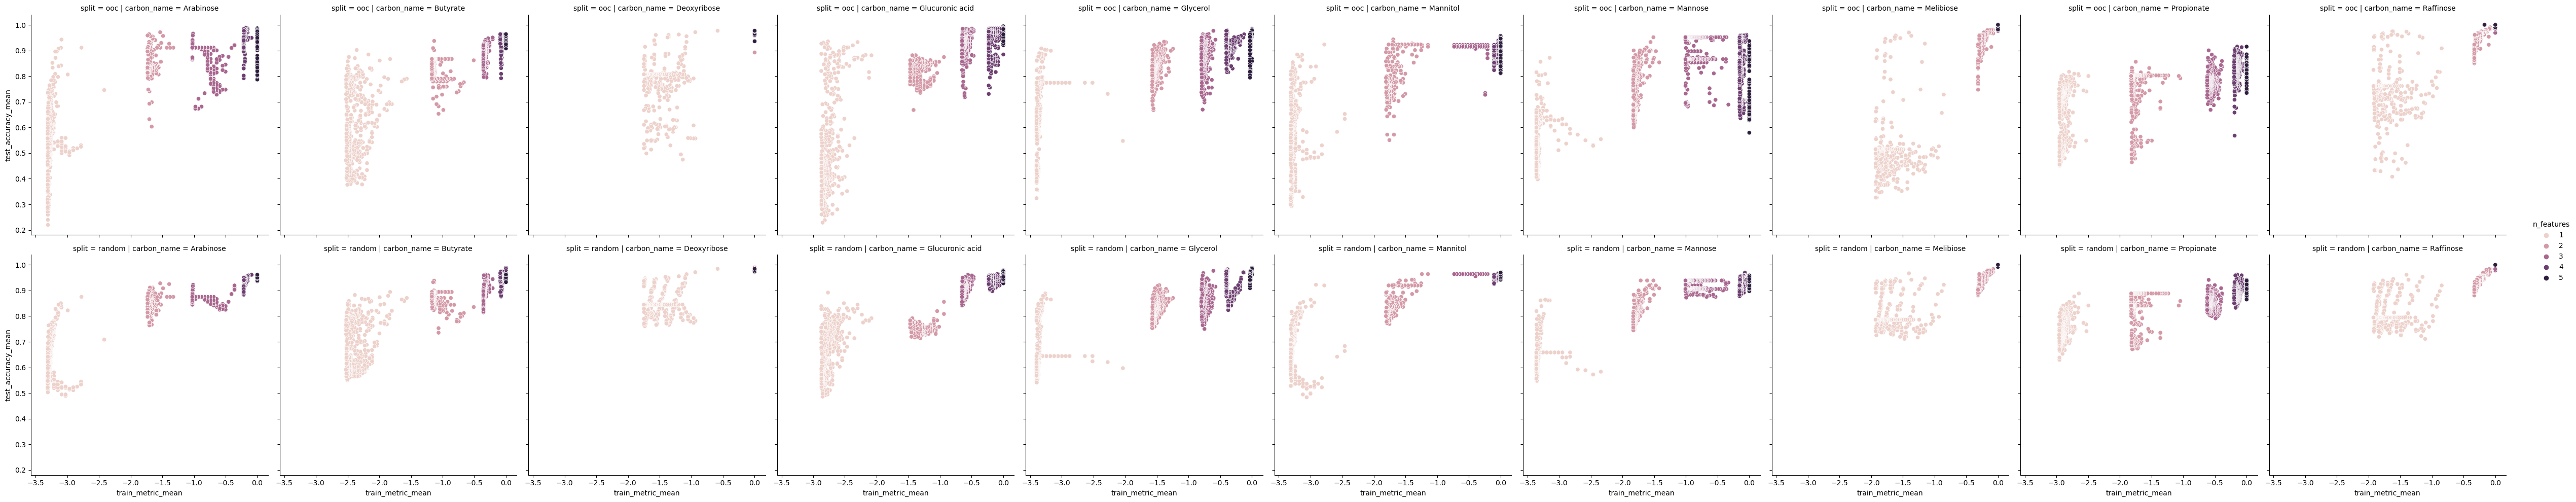

In [ ]:
sns.relplot(data=df_mean, hue='n_features', x='train_metric_mean', y='test_accuracy_mean', col='carbon_name', row='split',kind='scatter', facet_kws={'sharey':True})
plt.gcf()

Plot

In [ ]:
df_all=pd.read_pickle(f"{DIR_figure}/zeqian_split_{metric}.pk")


In [ ]:
df=df_all.groupby(['carbon_name','i_split','split','n_features']).head(100)

In [ ]:
N_top=20

dfs=[]
df_all['features_str']=df['features'].apply(lambda x: ','.join(np.sort(x)))

for keys, group in df_all.groupby(['carbon_name','split','n_features']):
    mean_metric=group.groupby('features_str')[['train_metric','metric_test']].mean().reset_index()
    mean_metric=mean_metric.sort_values(by=['train_metric'],ascending=False).iloc[:N_top,:]
    mean_metric['carbon_name']=keys[0]
    mean_metric['split']=keys[1]
    mean_metric['n_features']=keys[2]
    dfs.append(mean_metric)



In [ ]:
df=pd.concat(dfs,axis=0,ignore_index=True)

In [ ]:
df

,features_str,train_metric,metric_test,carbon_name,split,n_features
0,K10820,-2.415669,-0.296815,Arabinose,ooc,1
1,K23509,-2.415669,-0.296815,Arabinose,ooc,1
2,K23508,-2.415669,-0.296815,Arabinose,ooc,1
3,K10439,-2.774945,-1.012255,Arabinose,ooc,1
4,K07782,-2.782446,-1.230898,Arabinose,ooc,1
...,...,...,...,...,...,...
1995,"K02455,K08350,K12252,K12283,K25182",0.000000,0.000000,Raffinose,random,5
1996,"K01989,K02455,K12282,K12289,K25182",0.000000,0.000000,Raffinose,random,5
1997,"K01989,K02455,K12282,K12288,K25182",0.000000,0.000000,Raffinose,random,5
1998,"K01989,K02455,K12282,K12287,K25182",0.000000,0.000000,Raffinose,random,5


In [ ]:
from scipy.stats import pearsonr
cor=df.groupby(['carbon_name','split','n_features']).apply(lambda group: pearsonr(group['train_metric'],group['metric_test'])[0]).reset_index()

/home/zeqianli/scratch-midway3/miniconda3/envs/zeqian/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [ ]:
cor

,carbon_name,split,n_features,0
0,Arabinose,ooc,1,0.861818
1,Arabinose,ooc,2,-0.188732
2,Arabinose,ooc,3,0.800257
3,Arabinose,ooc,4,0.861496
4,Arabinose,ooc,5,NaN
...,...,...,...,...
95,Raffinose,random,1,0.082450
96,Raffinose,random,2,NaN
97,Raffinose,random,3,NaN
98,Raffinose,random,4,NaN


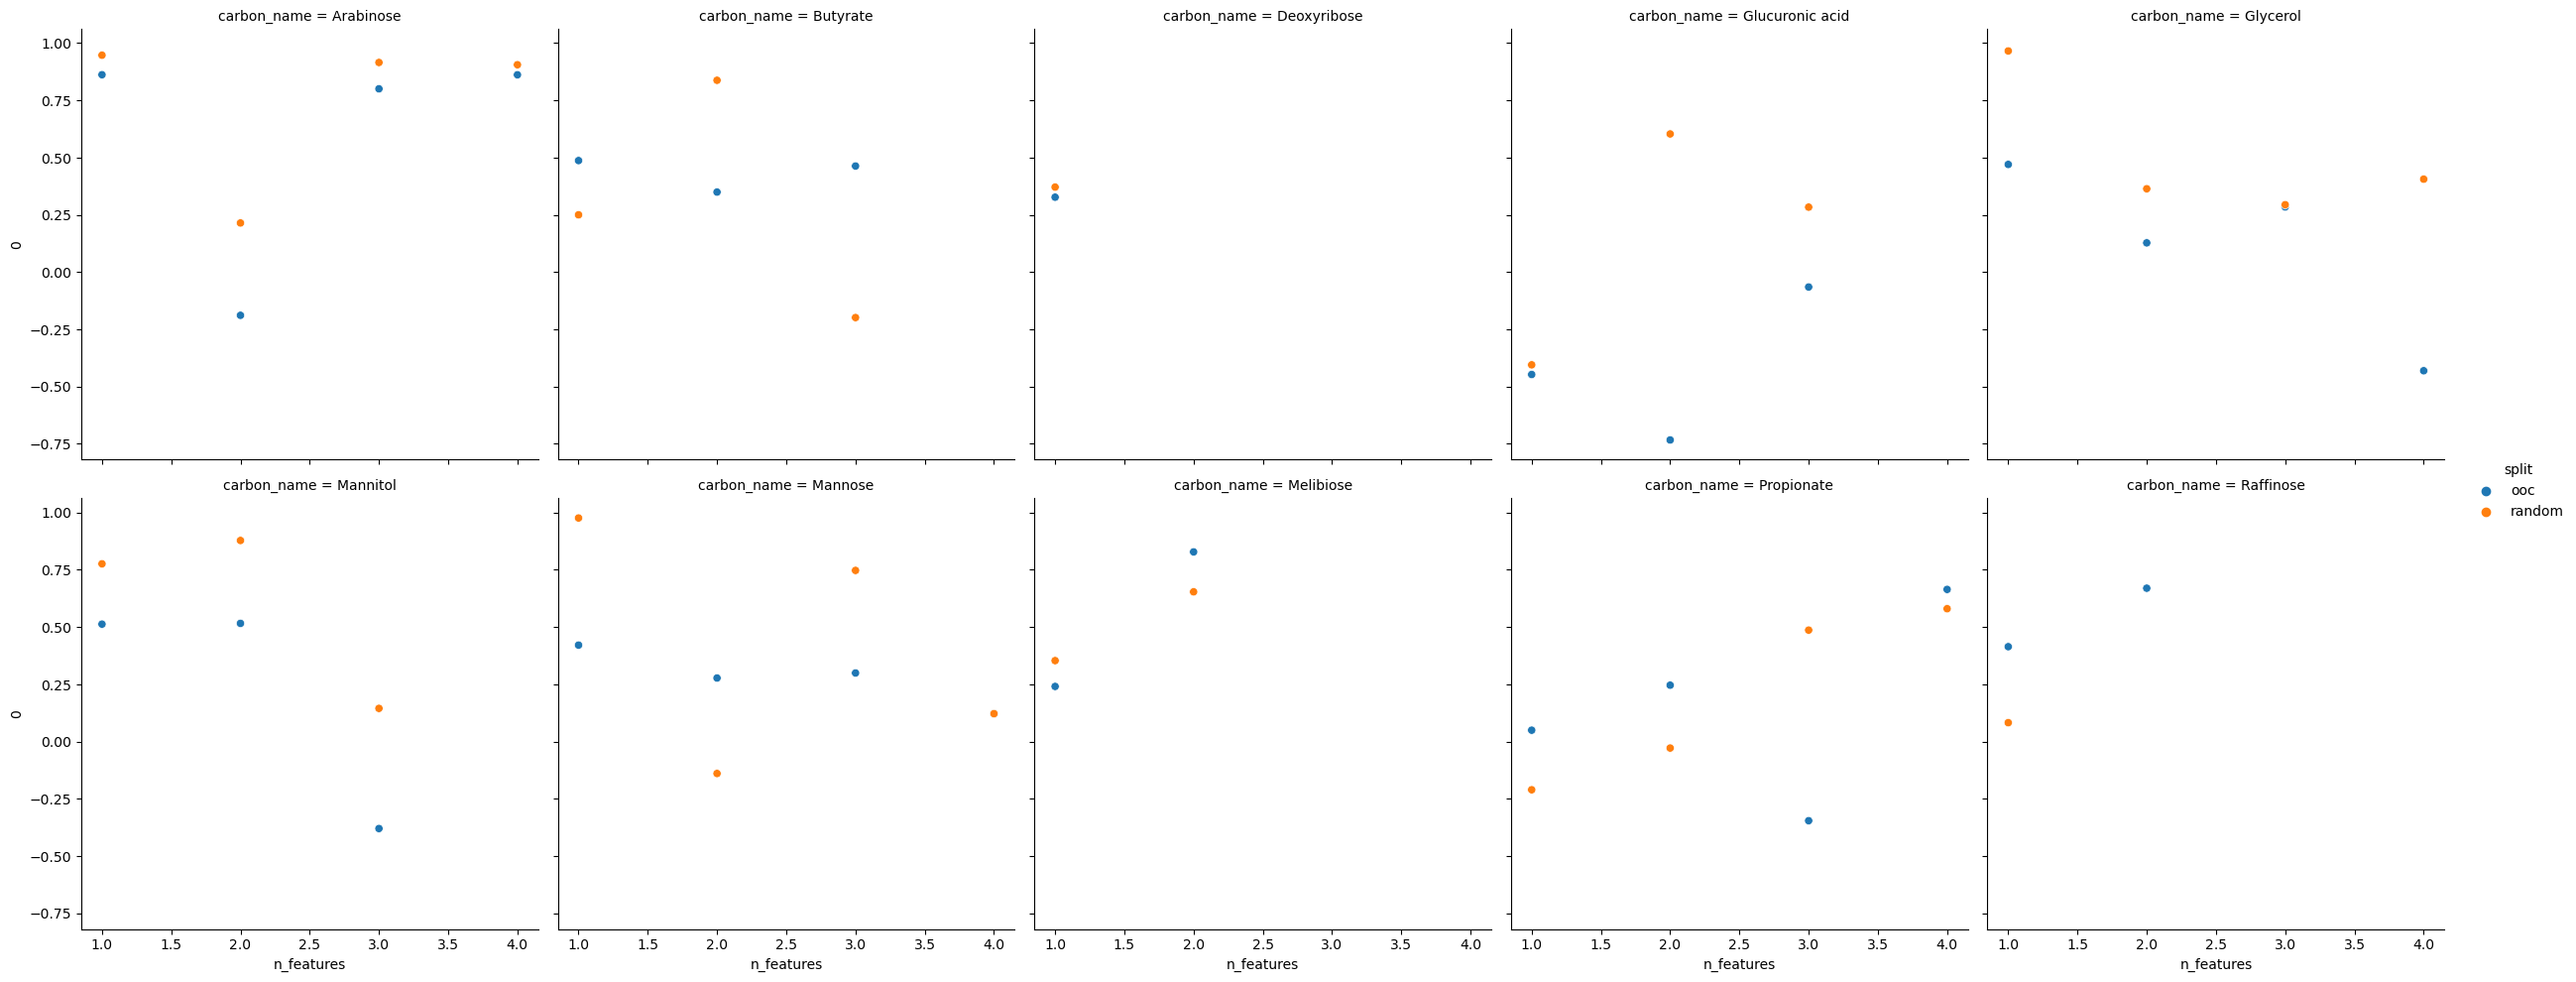

In [ ]:
sns.relplot(data=cor, hue='split',x='n_features', y=0,col='carbon_name',col_wrap=5)
plt.gcf()

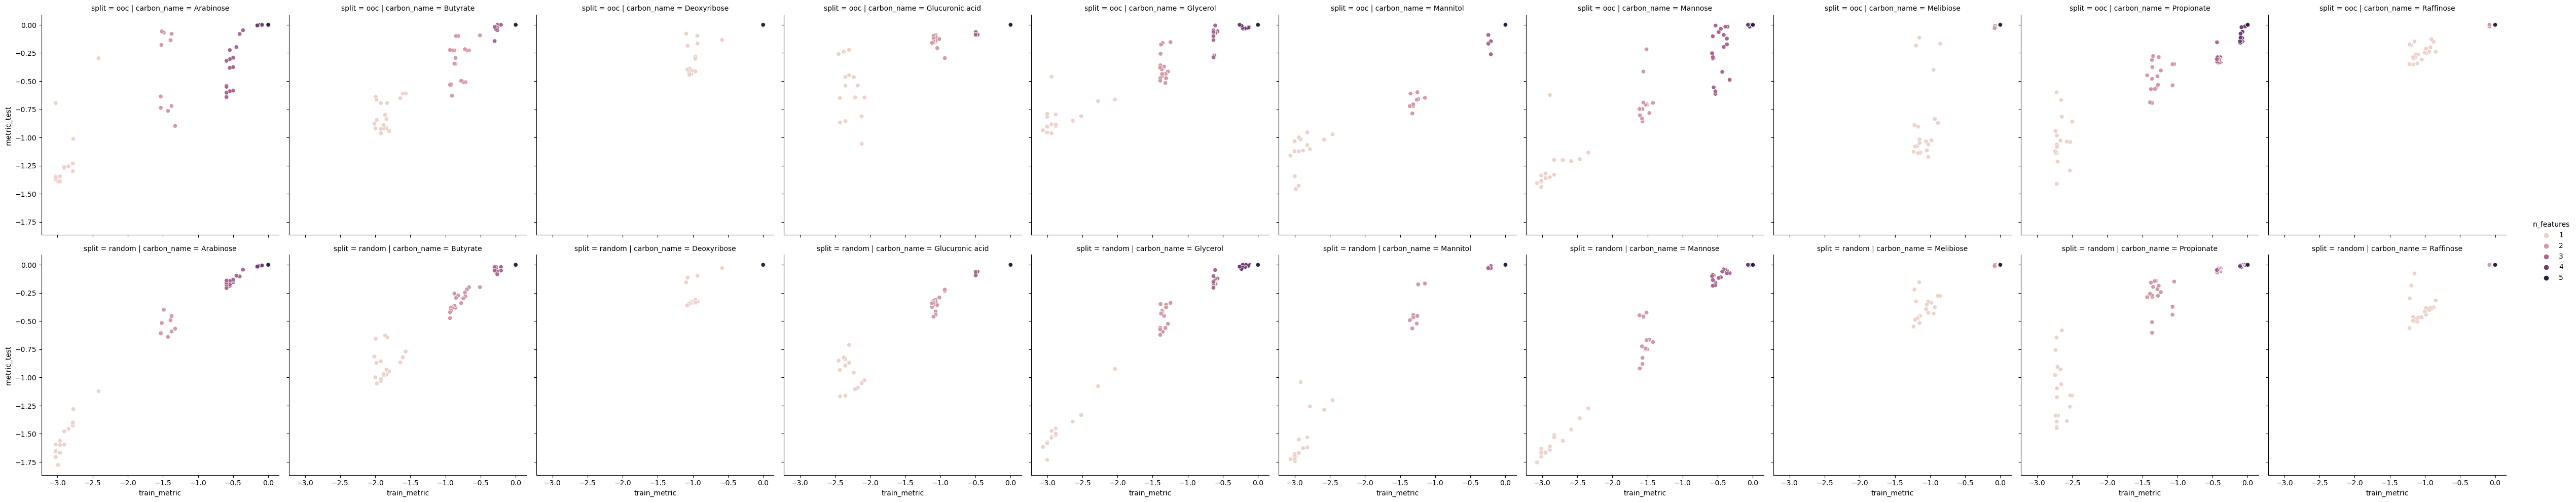

In [ ]:

sns.relplot(data=df, x='train_metric',y='metric_test',hue='n_features', row='split',col='carbon_name') 

plt.gcf()